## Adam Packer and Aaron Newman (08-apacker-newmanar)
## SIADS 593 Final Report
## Winter 2023
## Analysis Notebook

# 0.1 - Import necessary modules

In [57]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import warnings
warnings.filterwarnings('ignore')

# 0.2 - Read in data previously compiled in Setup workbook

In [99]:
compiled_df = pd.read_pickle('Compiled_data.pkl')

compiled_df

,date,location,loc_code,carrier,p_origin,p_dest,passengers,cases,deaths
0,2020-03-01,USA,USA,ALL,34527687.0,34527687.0,34527687.0,184104.0,4199.0
1,2020-03-01,USA,USA,04Q,274.0,274.0,274.0,184104.0,4199.0
2,2020-03-01,USA,USA,09Q,26506.0,26506.0,26506.0,184104.0,4199.0
3,2020-03-01,USA,USA,1EQ,637.0,637.0,637.0,184104.0,4199.0
4,2020-03-01,USA,USA,1QQ,417.0,417.0,417.0,184104.0,4199.0
...,...,...,...,...,...,...,...,...,...
29474,2022-11-01,"Salt Lake City, UT",SLC,OO,167276.0,168875.0,336151.0,5559.0,23.0
29475,2022-11-01,"Salt Lake City, UT",SLC,SY,258.0,255.0,513.0,5559.0,23.0
29476,2022-11-01,"Salt Lake City, UT",SLC,TQ,0.0,2.0,2.0,5559.0,23.0
29477,2022-11-01,"Salt Lake City, UT",SLC,UA,11601.0,11734.0,23335.0,5559.0,23.0


# 0.3 - Show a national overview of the data plotted over time

To orient the reader for the analysis, this code displays the COVID-related deaths, reported cases, and air passenger counts from March 2020 through November 2022. Note the differences in scale for the three plots, and the various peaks and troughs in each.

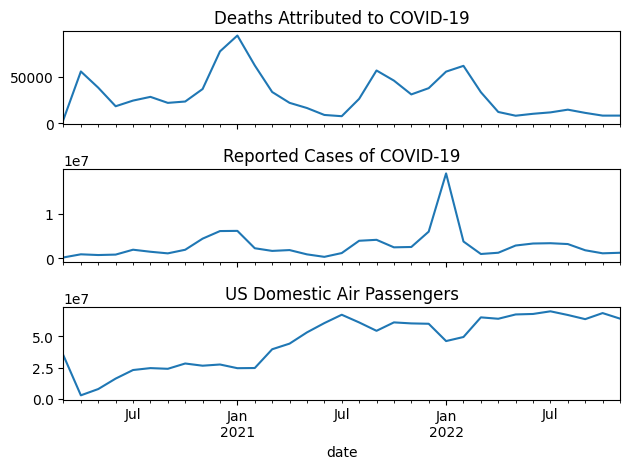

In [58]:
df_plot = compiled_df[(compiled_df.loc_code=='USA') & (compiled_df.carrier=='ALL')]
df_plot.index=df_plot.date
df_plot = df_plot[['passengers','cases','deaths']]
fig, axs = plt.subplots(3,1, sharex=True)
df_plot['deaths'].plot(ax=axs[0], title="Deaths Attributed to COVID-19")
df_plot['cases'].plot(ax=axs[1], title="Reported Cases of COVID-19")
df_plot['passengers'].plot(ax=axs[2], title="US Domestic Air Passengers")
plt.tight_layout()
plt.show()

# 1.0 - Function to perform a series of correlation calculations 

The function iterates through a range of months and performs correlation calculations between travel data and covid data starting with each month.  <br><br>
For example, if the range of months is from Jan 2021 through Dec 2021, this function would perform and gather correlation calculations <br>
&nbsp;&nbsp;&nbsp;&nbsp;first, starting from Jan 2021 through to the end of the data,<br>
&nbsp;&nbsp;&nbsp;&nbsp;then, starting from Feb 2021 through to the end of the data,<br>
&nbsp;&nbsp;&nbsp;&nbsp;...<br>
&nbsp;&nbsp;&nbsp;&nbsp;then, starting from Dec 2021 through to the end of the data.<br>
<br><b><i> df </i></b> - the dataframe containing the travel/covid data we are analyzing
<br><b><i> covid_column </i></b> - indicates whether we want to use covid cases or covid deaths for analysis
<br><b><i> numMonthsCutoff </i></b> - There is little value in calculating correlation metrics when the lists are only a few items long. This parameter is for cutting off a specified number of months at the end of the loop that wouldn't be of any analytical value.
<br><b><i> numlag </i></b> - how much lag (if any) we want to space between the covid data and the travel data

In [5]:
def perform_correlations(df, covid_column, numMonthsCutoff, numlag):
    corr_list = []
    
    for i in range(len(df)-1-numlag-numMonthsCutoff):
        
        # get the appropriate covid series, 
        # depending on whether we want cases or deaths
        # and whether or not we want there to be lag between the covid data and the travel data
        if (covid_column == 'cases'):
            if (numlag == 0):
                pearson_input1 = df.cases[i:]
            else:
                pearson_input1 = df.cases[i:-numlag]
        else: # covid_column == 'deaths'
            if (numlag == 0):
                pearson_input1 = df.deaths[i:]
            else:
                pearson_input1 = df.deaths[i:-numlag]
        
        pearson_input2 = df.passengers[i+numlag:]
            
        corr = pearsonr(pearson_input1, pearson_input2)
        corr_list.append([df.iloc[i].date.strftime("%Y-%m-%d"),
                         len(pearson_input1), corr[0], corr[1], corr[1]<0.05])            
        
        df_corr = pd.DataFrame(corr_list, 
                           columns=['Start Month','Series Length','Pearson Corr','p-value','Significant (95%)'])
        df_corr.index = df_corr['Start Month']

    if not corr_list:
        return pd.DataFrame()
    return df_corr[['Pearson Corr', 'p-value']]

# 2.0 - Function to display correlation chart

This function uses Altair to display correlation data.<br>
<br><b><i>df</i></b> - the dataframe of correlation data we want to plot
<br><b><i>titleText</i></b> - the title for this chart

In [48]:
def get_chart(df, titleText):
    
    df['Significance Threshold'] = 0.05
    
    base = alt.Chart(df).mark_line().encode(
        alt.X('Start Month', axis=alt.Axis(tickMinStep=1))
    )    
    
    scale = alt.Scale(domain=['Pearson Corr', 'p-value', 'Significance Threshold'], range=['blue', 'orange', 'red'])
    
    lines = base.transform_fold(
         ['p-value', 'Significance Threshold']
    ).mark_line().encode(
        alt.X('Start Month', axis=alt.Axis(tickMinStep=1)),
        alt.Y('value:Q', scale=alt.Scale(domain=[0, 1]),
              axis=alt.Axis(title='p-value', titleColor='orange')),
        color=alt.Color('key:N', scale=scale,legend=alt.Legend(title='Legend'))
    )
    
    bar = base.mark_bar(size=20).encode(
        alt.Y('Pearson Corr', scale=alt.Scale(domain=[-1, 1]),
                axis=alt.Axis(title='Pearson Correlation', titleColor='#063970'))
    )
    
    multi_chart = alt.layer(bar, lines).resolve_scale(
        y = 'independent'
    ).properties(width=300, height=300, title=titleText)
    
    return multi_chart  

# 3.0 - Function to run correlation report on a location and carrier

<b><i> df </i></b> - the dataframe containing the travel/covid data we are analyzing
<br><b><i> covid_column </i></b> - indicates whether we want to use covid cases or covid deaths for analysis
<br><b><i> numMonthsCutoff </i></b> - There is little value in calculating correlation metrics when the lists are only a few items long. This parameter is for cutting off a specified number of months at the end of the loop that wouldn't be of any analytical value.
<br><b><i> lag </i></b> - if we want to show lag, no lag, or both
<br><b><i> loc_code </i></b> - 3-char location code
<br><b><i> loc_name </i></b> - location name
<br><b><i> carrier </i></b> - carrier code
<br><b><i> date_from, date_to </i></b> - if we want to analyze only a slice (time-wise) of the data available

In [40]:
def process_loc(df, covid_column, numMonthsCutoff, lag, loc_code, loc_name, carrier, 
                date_from='1999-12-31', date_to='2099-12-31'):
    eflag = 0
    print('\n')
    print(loc_name + ' - ' + carrier)
    loc_df = df.loc[df['loc_code']==loc_code]
    loc_df = loc_df.loc[df['carrier']==carrier]
    loc_df = loc_df.loc[loc_df['date'] >= date_from]
    loc_df = loc_df.loc[loc_df['date'] <= date_to]
    
    chart_title = covid_column.title() + ' - ' + loc_name + ' - ' + carrier
    
    if ((lag == 'zero') | (lag == 'both')):
        result_df = perform_correlations(loc_df, covid_column, numMonthsCutoff, 0)
        print('without lag')
        print(result_df)
        if ((len(result_df.index) > 0) & (result_df.isnull().values.any() == False) ):
            chart1 = get_chart(result_df.reset_index(), chart_title + ' - No lag')
        else:
            print('not enough data')
            eflag = 1
    
    if ((lag == 'one') | (lag == 'both')):
        result_df = perform_correlations(loc_df, covid_column, numMonthsCutoff, 1)
        print('\nwith 1 month lag')
        print(result_df)  
        if ( (len(result_df.index) > 0) & (result_df.isnull().values.any() == False) ):
            chart2 = get_chart(result_df.reset_index(), chart_title + ' - 1 month lag')
        else:
            print('not enough data')   
            eflag = 1
    
    if (eflag == 0):
        if (lag == 'zero'):
            chart1.display()
        elif (lag == 'one'):
            chart2.display()
        else: # lag == 'both'
            alt.concat(chart1, chart2).display()

# 4.0 - Analysis

### 4.1 - parameter defaults

In [103]:
# default values for parameters
default_loc_code = 'USA'
default_loc_name = 'United States'
default_carrier = 'ALL'
date_from = '2020-01-01'
date_to = '2099-12-31'
covid_column = 'deaths'   # valid values are 'cases' or 'deaths'

# the number of months to truncate at the end (correlations on series only a few units long are not beneficial)
numMonthsCutoff = 5   

# are we doing anything with lag?
# 'zero' - not using any lag
# 'one' - implementing one month lag
# 'both' - comparing zero lag and one month lag
numlag = 'zero'

# get list of all locations
loc_list = compiled_df['loc_code'].unique()

# get list of all carriers
car_list = np.sort(compiled_df['carrier'].unique())

# a curated list of carriers
cur_car_list = ['DL', 'AA', 'UA', 'WN', 'AS', 'B6']   

### 4.2 - New Cases / Passenger Counts, zero lag vs. one month lag

In [52]:
print('\n')
print('When correlating passenger counts with new covid cases, we see a stronger correlation when')
print('we implement a one month lag between the travel data and the covid data.')

covid_column = 'cases'
numlag = 'both'
process_loc(compiled_df, covid_column, numMonthsCutoff, numlag, 
            default_loc_code, default_loc_name, default_carrier, 
            date_from, date_to) 



When correlating passenger counts with new covid cases, we see a stronger correlation when
we implement a one month lag between the travel data and the covid data.


United States - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.037321  0.836638
2020-04-01       0.023150  0.899918
2020-05-01      -0.022187  0.905694
2020-06-01      -0.077061  0.685664
2020-07-01      -0.129059  0.504626
2020-08-01      -0.158012  0.421938
2020-09-01      -0.199422  0.318641
2020-10-01      -0.259986  0.199609
2020-11-01      -0.305044  0.138144
2020-12-01      -0.307944  0.143215
2021-01-01      -0.270662  0.211615
2021-02-01      -0.217856  0.330078
2021-03-01      -0.336873  0.135368
2021-04-01      -0.455352  0.043642
2021-05-01      -0.584785  0.008544
2021-06-01      -0.669932  0.002352
2021-07-01      -0.695149  0.001950
2021-08-01      -0.686492  0.003314
2021-09-01      -0.686619  0.004695
2021-10-01      -0.712837  0.004216
2021-11-

alt.ConcatChart(...)

### 4.3 - New Deaths / Passenger counts, zero lag vs. one month lag

In [53]:
print('\n')
print('When correlating passenger counts with new deaths, not having any lag shows the stronger correlation.')
print('Correlating passenger counts with new deaths instead of new cases also generates more consistently strong p-values.')

covid_column = 'deaths'
numlag = 'both'
process_loc(compiled_df, covid_column, numMonthsCutoff, numlag, 
            default_loc_code, default_loc_name, default_carrier, 
            date_from, date_to) 



When correlating passenger counts with new deaths, not having any lag shows the stronger correlation.
Correlating passenger counts with new deaths instead of new cases also generates more consistently strong p-values.


United States - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.464119  6.513660e-03
2020-04-01      -0.499233  3.628176e-03
2020-05-01      -0.467035  8.077516e-03
2020-06-01      -0.480085  7.254740e-03
2020-07-01      -0.550763  1.960910e-03
2020-08-01      -0.595571  8.266943e-04
2020-09-01      -0.633808  3.859924e-04
2020-10-01      -0.706153  5.553557e-05
2020-11-01      -0.772950  5.923315e-06
2020-12-01      -0.820520  9.112420e-07
2021-01-01      -0.785577  8.941833e-06
2021-02-01      -0.686816  4.147972e-04
2021-03-01      -0.604581  3.694529e-03
2021-04-01      -0.646806  2.055512e-03
2021-05-01      -0.774886  9.778890e-05
2021-06-01      -0.853978  6.505079e-06
2021-07-01      -0.887476 

alt.ConcatChart(...)

 ### 4.4 - New Cases / Passenger Counts, one month lag - each individual location

In [59]:
# cases
covid_column = 'cases'
numlag = 'one'

# loop through all locations
for loc_code in loc_list:
    loc_name = compiled_df.loc[compiled_df['loc_code'] == loc_code]['location'].unique()[0]
    process_loc(compiled_df, covid_column, numMonthsCutoff, numlag, 
                loc_code, loc_name, default_carrier, date_from, date_to)



USA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.054383  0.767525
2020-04-01      -0.003034  0.987076
2020-05-01      -0.051996  0.784947
2020-06-01      -0.103737  0.592292
2020-07-01      -0.151396  0.441871
2020-08-01      -0.184150  0.357839
2020-09-01      -0.235690  0.246415
2020-10-01      -0.296610  0.149936
2020-11-01      -0.359954  0.084037
2020-12-01      -0.373935  0.078794
2021-01-01      -0.350946  0.109285
2021-02-01      -0.328909  0.145442
2021-03-01      -0.424763  0.061927
2021-04-01      -0.557128  0.013212
2021-05-01      -0.618290  0.006238
2021-06-01      -0.636306  0.006031
2021-07-01      -0.621742  0.010132
2021-08-01      -0.635867  0.010836
2021-09-01      -0.667198  0.009142
2021-10-01      -0.667746  0.012629
2021-11-01      -0.683211  0.014320
2021-12-01      -0.703186  0.015779
2022-01-01      -0.895452  0.000460
2022-02-01       0.225579  0.559497
2022-03-01       0.372972  0.36282

alt.LayerChart(...)



Dallas/Fort Worth, TX - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.074951  0.683501
2020-04-01      -0.163307  0.380050
2020-05-01      -0.249727  0.183225
2020-06-01      -0.321543  0.088962
2020-07-01      -0.369809  0.052755
2020-08-01      -0.395859  0.040957
2020-09-01      -0.439652  0.024615
2020-10-01      -0.486916  0.013570
2020-11-01      -0.553402  0.005029
2020-12-01      -0.578365  0.003841
2021-01-01      -0.566839  0.005946
2021-02-01      -0.519616  0.015769
2021-03-01      -0.558762  0.010439
2021-04-01      -0.655223  0.002326
2021-05-01      -0.694110  0.001395
2021-06-01      -0.688903  0.002224
2021-07-01      -0.676033  0.004041
2021-08-01      -0.693083  0.004173
2021-09-01      -0.694478  0.005849
2021-10-01      -0.712331  0.006295
2021-11-01      -0.713038  0.009237
2021-12-01      -0.720084  0.012453
2022-01-01      -0.921449  0.000151
2022-02-01      -0.238241  0.537033
2022-03-01      

alt.LayerChart(...)



Pittsburgh, PA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.048426  0.792402
2020-04-01      -0.004408  0.981226
2020-05-01      -0.058324  0.759497
2020-06-01      -0.109296  0.572495
2020-07-01      -0.159339  0.418001
2020-08-01      -0.197902  0.322417
2020-09-01      -0.257154  0.204725
2020-10-01      -0.318063  0.121274
2020-11-01      -0.388932  0.060329
2020-12-01      -0.423274  0.044169
2021-01-01      -0.364627  0.095230
2021-02-01      -0.395379  0.076062
2021-03-01      -0.526959  0.016971
2021-04-01      -0.660188  0.002097
2021-05-01      -0.703224  0.001131
2021-06-01      -0.720007  0.001117
2021-07-01      -0.713846  0.001898
2021-08-01      -0.736835  0.001727
2021-09-01      -0.785623  0.000867
2021-10-01      -0.785570  0.001459
2021-11-01      -0.785572  0.002459
2021-12-01      -0.786698  0.004071
2022-01-01      -0.928734  0.000103
2022-02-01      -0.145016  0.709705
2022-03-01       0.0497

alt.LayerChart(...)



Denver, CO - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.053754  0.770139
2020-04-01      -0.009006  0.961649
2020-05-01      -0.066890  0.725441
2020-06-01      -0.120856  0.532301
2020-07-01      -0.175419  0.371932
2020-08-01      -0.220589  0.268872
2020-09-01      -0.283216  0.160916
2020-10-01      -0.338890  0.097488
2020-11-01      -0.391515  0.058497
2020-12-01      -0.339924  0.112516
2021-01-01      -0.325621  0.139195
2021-02-01      -0.423823  0.055537
2021-03-01      -0.532854  0.015562
2021-04-01      -0.629206  0.003898
2021-05-01      -0.652765  0.003317
2021-06-01      -0.655102  0.004313
2021-07-01      -0.643149  0.007196
2021-08-01      -0.635465  0.010902
2021-09-01      -0.644784  0.012789
2021-10-01      -0.644369  0.017440
2021-11-01      -0.660162  0.019473
2021-12-01      -0.662114  0.026452
2022-01-01      -0.780528  0.007714
2022-02-01       0.062110  0.873876
2022-03-01       0.260247  

alt.LayerChart(...)



Atlanta, GA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.016084  0.930375
2020-04-01      -0.049812  0.790153
2020-05-01      -0.114504  0.546839
2020-06-01      -0.186266  0.333317
2020-07-01      -0.247917  0.203369
2020-08-01      -0.268058  0.176422
2020-09-01      -0.301828  0.133994
2020-10-01      -0.364449  0.073272
2020-11-01      -0.446804  0.028607
2020-12-01      -0.516928  0.011545
2021-01-01      -0.507043  0.016020
2021-02-01      -0.421423  0.057085
2021-03-01      -0.500165  0.024715
2021-04-01      -0.726639  0.000425
2021-05-01      -0.768703  0.000193
2021-06-01      -0.781441  0.000212
2021-07-01      -0.771295  0.000468
2021-08-01      -0.778491  0.000629
2021-09-01      -0.772898  0.001190
2021-10-01      -0.781832  0.001592
2021-11-01      -0.785510  0.002462
2021-12-01      -0.827447  0.001670
2022-01-01      -0.933496  0.000079
2022-02-01      -0.186538  0.630835
2022-03-01      -0.138606 

alt.LayerChart(...)



Austin, TX - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.078497  0.669351
2020-04-01       0.040794  0.827516
2020-05-01       0.003365  0.985918
2020-06-01      -0.033245  0.864063
2020-07-01      -0.052084  0.792385
2020-08-01      -0.055513  0.783303
2020-09-01      -0.082548  0.688496
2020-10-01      -0.124334  0.553752
2020-11-01      -0.175957  0.410827
2020-12-01      -0.211292  0.333145
2021-01-01      -0.226467  0.310837
2021-02-01      -0.178146  0.439764
2021-03-01      -0.247526  0.292718
2021-04-01      -0.341775  0.152094
2021-05-01      -0.419072  0.083443
2021-06-01      -0.466231  0.059241
2021-07-01      -0.489594  0.054242
2021-08-01      -0.552331  0.032758
2021-09-01      -0.569944  0.033348
2021-10-01      -0.571226  0.041431
2021-11-01      -0.593357  0.041975
2021-12-01      -0.630524  0.037545
2022-01-01      -0.950400  0.000025
2022-02-01      -0.566641  0.111653
2022-03-01      -0.542402  

alt.LayerChart(...)



Phoenix, AZ - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.039058  0.831922
2020-04-01      -0.019257  0.918106
2020-05-01      -0.082222  0.665781
2020-06-01      -0.140155  0.468360
2020-07-01      -0.163042  0.407122
2020-08-01      -0.155640  0.438219
2020-09-01      -0.214856  0.291860
2020-10-01      -0.281941  0.172120
2020-11-01      -0.365429  0.079093
2020-12-01      -0.423046  0.044295
2021-01-01      -0.386042  0.075975
2021-02-01      -0.217829  0.342849
2021-03-01      -0.247800  0.292167
2021-04-01      -0.307504  0.200304
2021-05-01      -0.324661  0.188684
2021-06-01      -0.327286  0.199731
2021-07-01      -0.310253  0.242207
2021-08-01      -0.346087  0.206373
2021-09-01      -0.363109  0.201934
2021-10-01      -0.364433  0.220861
2021-11-01      -0.363150  0.245944
2021-12-01      -0.367555  0.266115
2022-01-01      -0.427242  0.218133
2022-02-01       0.147915  0.704110
2022-03-01      -0.744161 

alt.LayerChart(...)



Seattle, WA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.143441  0.433506
2020-04-01       0.115295  0.536827
2020-05-01       0.088269  0.642767
2020-06-01       0.057884  0.765509
2020-07-01       0.029375  0.882041
2020-08-01       0.004742  0.981272
2020-09-01      -0.027529  0.893803
2020-10-01      -0.068375  0.745368
2020-11-01      -0.116705  0.587077
2020-12-01      -0.143742  0.512899
2021-01-01      -0.181681  0.418409
2021-02-01      -0.253299  0.267915
2021-03-01      -0.354402  0.125241
2021-04-01      -0.445702  0.055808
2021-05-01      -0.481475  0.043066
2021-06-01      -0.475126  0.053932
2021-07-01      -0.452896  0.078132
2021-08-01      -0.430874  0.108846
2021-09-01      -0.436801  0.118372
2021-10-01      -0.442654  0.129838
2021-11-01      -0.466586  0.126239
2021-12-01      -0.517324  0.103162
2022-01-01      -0.698994  0.024499
2022-02-01       0.630245  0.068846
2022-03-01       0.857717 

alt.LayerChart(...)



Cleveland, OH - ALL

with 1 month lag
             Pearson Corr       p-value
Start Month                            
2020-03-01       0.020297  9.122014e-01
2020-04-01      -0.043933  8.144632e-01
2020-05-01      -0.111542  5.573263e-01
2020-06-01      -0.173176  3.689868e-01
2020-07-01      -0.223660  2.525795e-01
2020-08-01      -0.271543  1.706502e-01
2020-09-01      -0.346264  8.312403e-02
2020-10-01      -0.425829  3.380664e-02
2020-11-01      -0.527677  8.048165e-03
2020-12-01      -0.522913  1.046182e-02
2021-01-01      -0.492884  1.977151e-02
2021-02-01      -0.538607  1.176596e-02
2021-03-01      -0.675365  1.084400e-03
2021-04-01      -0.810215  2.608351e-05
2021-05-01      -0.862891  4.047796e-06
2021-06-01      -0.870957  5.368164e-06
2021-07-01      -0.864992  1.522720e-05
2021-08-01      -0.880712  1.461194e-05
2021-09-01      -0.939256  6.357593e-07
2021-10-01      -0.939261  1.928909e-06
2021-11-01      -0.944912  3.641267e-06
2021-12-01      -0.946912  9.920575e-06


alt.LayerChart(...)



Nashville, TN - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.055292  0.763745
2020-04-01      -0.127881  0.492982
2020-05-01      -0.197745  0.294887
2020-06-01      -0.256334  0.179520
2020-07-01      -0.302798  0.117295
2020-08-01      -0.315975  0.108360
2020-09-01      -0.362094  0.069099
2020-10-01      -0.414461  0.039408
2020-11-01      -0.459990  0.023719
2020-12-01      -0.457899  0.028009
2021-01-01      -0.354430  0.105570
2021-02-01      -0.310158  0.171213
2021-03-01      -0.376126  0.102165
2021-04-01      -0.452272  0.051872
2021-05-01      -0.494432  0.036996
2021-06-01      -0.517010  0.033570
2021-07-01      -0.513529  0.041893
2021-08-01      -0.542505  0.036668
2021-09-01      -0.530522  0.050974
2021-10-01      -0.547871  0.052586
2021-11-01      -0.566428  0.054845
2021-12-01      -0.611324  0.045677
2022-01-01      -0.860020  0.001414
2022-02-01      -0.439672  0.236340
2022-03-01       0.09199

alt.LayerChart(...)



Boston, MA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.017645  0.923640
2020-04-01      -0.059435  0.750785
2020-05-01      -0.066224  0.728072
2020-06-01      -0.088659  0.647423
2020-07-01      -0.125706  0.523875
2020-08-01      -0.170564  0.394993
2020-09-01      -0.227102  0.264549
2020-10-01      -0.286578  0.164874
2020-11-01      -0.350154  0.093463
2020-12-01      -0.391582  0.064629
2021-01-01      -0.357430  0.102447
2021-02-01      -0.322674  0.153687
2021-03-01      -0.401955  0.078948
2021-04-01      -0.477569  0.038654
2021-05-01      -0.537493  0.021422
2021-06-01      -0.599142  0.011034
2021-07-01      -0.621941  0.010101
2021-08-01      -0.647534  0.009056
2021-09-01      -0.713776  0.004143
2021-10-01      -0.725969  0.004961
2021-11-01      -0.764126  0.003809
2021-12-01      -0.818432  0.002071
2022-01-01      -0.901465  0.000366
2022-02-01       0.127243  0.744254
2022-03-01       0.248957  

alt.LayerChart(...)



Washington, DC - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.047746  0.795256
2020-04-01      -0.001685  0.992823
2020-05-01      -0.028572  0.880865
2020-06-01      -0.035012  0.856910
2020-07-01      -0.062170  0.753311
2020-08-01      -0.093748  0.641855
2020-09-01      -0.130892  0.523898
2020-10-01      -0.172828  0.408723
2020-11-01      -0.226993  0.286119
2020-12-01      -0.259734  0.231365
2021-01-01      -0.240727  0.280511
2021-02-01      -0.204709  0.373395
2021-03-01      -0.262265  0.263969
2021-04-01      -0.335046  0.160855
2021-05-01      -0.383999  0.115666
2021-06-01      -0.441422  0.076094
2021-07-01      -0.458089  0.074358
2021-08-01      -0.474151  0.074159
2021-09-01      -0.526175  0.053264
2021-10-01      -0.539165  0.057246
2021-11-01      -0.555324  0.060877
2021-12-01      -0.590472  0.055802
2022-01-01      -0.879867  0.000786
2022-02-01       0.271994  0.478932
2022-03-01       0.2571

alt.LayerChart(...)



Chicago, IL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.072936  0.691588
2020-04-01      -0.140707  0.450251
2020-05-01      -0.182581  0.334197
2020-06-01      -0.210011  0.274198
2020-07-01      -0.257342  0.186155
2020-08-01      -0.306497  0.119961
2020-09-01      -0.355306  0.074872
2020-10-01      -0.409967  0.041815
2020-11-01      -0.455955  0.025137
2020-12-01      -0.401882  0.057314
2021-01-01      -0.387239  0.074993
2021-02-01      -0.442393  0.044627
2021-03-01      -0.558638  0.010460
2021-04-01      -0.676992  0.001454
2021-05-01      -0.718751  0.000777
2021-06-01      -0.725356  0.000983
2021-07-01      -0.711691  0.001987
2021-08-01      -0.701312  0.003576
2021-09-01      -0.707407  0.004656
2021-10-01      -0.702277  0.007442
2021-11-01      -0.726688  0.007426
2021-12-01      -0.753418  0.007421
2022-01-01      -0.780987  0.007654
2022-02-01       0.704047  0.034259
2022-03-01       0.776331 

alt.LayerChart(...)



Charlotte, NC - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.039466  0.830192
2020-04-01      -0.034938  0.851984
2020-05-01      -0.109457  0.564763
2020-06-01      -0.177469  0.357050
2020-07-01      -0.223276  0.253416
2020-08-01      -0.250816  0.206987
2020-09-01      -0.294706  0.143880
2020-10-01      -0.330112  0.107047
2020-11-01      -0.397888  0.054160
2020-12-01      -0.457477  0.028173
2021-01-01      -0.486407  0.021708
2021-02-01      -0.502597  0.020230
2021-03-01      -0.550914  0.011820
2021-04-01      -0.565467  0.011629
2021-05-01      -0.562177  0.015168
2021-06-01      -0.554334  0.020934
2021-07-01      -0.533805  0.033196
2021-08-01      -0.535522  0.039652
2021-09-01      -0.532670  0.049868
2021-10-01      -0.571343  0.041380
2021-11-01      -0.572330  0.051815
2021-12-01      -0.581293  0.060708
2022-01-01      -0.810552  0.004453
2022-02-01       0.171043  0.659937
2022-03-01       0.33196

alt.LayerChart(...)



Columbus, OH - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.017996  0.922124
2020-04-01      -0.081768  0.661903
2020-05-01      -0.140580  0.458716
2020-06-01      -0.189412  0.325069
2020-07-01      -0.233455  0.231847
2020-08-01      -0.270148  0.172944
2020-09-01      -0.328228  0.101620
2020-10-01      -0.384913  0.057436
2020-11-01      -0.452804  0.026291
2020-12-01      -0.452991  0.029957
2021-01-01      -0.407221  0.059970
2021-02-01      -0.407394  0.066795
2021-03-01      -0.501693  0.024209
2021-04-01      -0.627724  0.004009
2021-05-01      -0.700411  0.001208
2021-06-01      -0.713163  0.001309
2021-07-01      -0.705064  0.002284
2021-08-01      -0.744135  0.001466
2021-09-01      -0.785841  0.000863
2021-10-01      -0.785068  0.001477
2021-11-01      -0.797083  0.001906
2021-12-01      -0.809780  0.002520
2022-01-01      -0.903413  0.000338
2022-02-01       0.177243  0.648243
2022-03-01       0.194618

alt.LayerChart(...)



St. Louis, MO - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.046956  0.798571
2020-04-01      -0.113099  0.544662
2020-05-01      -0.172903  0.360875
2020-06-01      -0.222329  0.246377
2020-07-01      -0.262865  0.176554
2020-08-01      -0.288507  0.144446
2020-09-01      -0.324201  0.106139
2020-10-01      -0.368990  0.069499
2020-11-01      -0.414141  0.044227
2020-12-01      -0.375274  0.077643
2021-01-01      -0.339605  0.122036
2021-02-01      -0.355223  0.114061
2021-03-01      -0.433693  0.056080
2021-04-01      -0.542081  0.016503
2021-05-01      -0.608583  0.007358
2021-06-01      -0.624670  0.007344
2021-07-01      -0.625077  0.009621
2021-08-01      -0.642337  0.009818
2021-09-01      -0.659920  0.010224
2021-10-01      -0.663817  0.013357
2021-11-01      -0.690976  0.012836
2021-12-01      -0.741587  0.008993
2022-01-01      -0.864244  0.001257
2022-02-01       0.465872  0.206264
2022-03-01       0.58052

alt.LayerChart(...)



Detroit, MI - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.118062  0.519872
2020-04-01       0.072562  0.698078
2020-05-01       0.050202  0.792205
2020-06-01      -0.002986  0.987736
2020-07-01      -0.055002  0.781023
2020-08-01      -0.104099  0.605348
2020-09-01      -0.163793  0.423984
2020-10-01      -0.227555  0.273975
2020-11-01      -0.302045  0.151436
2020-12-01      -0.295130  0.171580
2021-01-01      -0.338090  0.123818
2021-02-01      -0.501785  0.020466
2021-03-01      -0.693398  0.000699
2021-04-01      -0.816963  0.000020
2021-05-01      -0.811768  0.000043
2021-06-01      -0.814205  0.000069
2021-07-01      -0.805343  0.000167
2021-08-01      -0.797098  0.000373
2021-09-01      -0.831484  0.000228
2021-10-01      -0.832205  0.000417
2021-11-01      -0.834606  0.000733
2021-12-01      -0.833819  0.001424
2022-01-01      -0.913352  0.000222
2022-02-01      -0.017427  0.964508
2022-03-01      -0.055217 

alt.LayerChart(...)



Houston, TX - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.101472  0.580534
2020-04-01       0.037454  0.841451
2020-05-01      -0.027084  0.887028
2020-06-01      -0.096206  0.619577
2020-07-01      -0.148842  0.449701
2020-08-01      -0.165341  0.409837
2020-09-01      -0.193618  0.343273
2020-10-01      -0.250974  0.226236
2020-11-01      -0.323852  0.122638
2020-12-01      -0.384492  0.070065
2021-01-01      -0.422439  0.050165
2021-02-01      -0.428598  0.052555
2021-03-01      -0.493539  0.027005
2021-04-01      -0.583138  0.008778
2021-05-01      -0.650930  0.003437
2021-06-01      -0.665336  0.003560
2021-07-01      -0.644673  0.007016
2021-08-01      -0.650389  0.008658
2021-09-01      -0.634712  0.014751
2021-10-01      -0.656554  0.014787
2021-11-01      -0.654689  0.020873
2021-12-01      -0.665101  0.025540
2022-01-01      -0.855487  0.001597
2022-02-01      -0.340278  0.370244
2022-03-01      -0.282866 

alt.LayerChart(...)



Orlando, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.190544  0.296205
2020-04-01       0.142579  0.444183
2020-05-01       0.087891  0.644196
2020-06-01       0.026967  0.889561
2020-07-01      -0.010047  0.959533
2020-08-01      -0.000918  0.996374
2020-09-01      -0.055639  0.787191
2020-10-01      -0.134606  0.521195
2020-11-01      -0.221233  0.298850
2020-12-01      -0.282058  0.192257
2021-01-01      -0.329613  0.134132
2021-02-01      -0.366800  0.101933
2021-03-01      -0.418898  0.066011
2021-04-01      -0.469916  0.042342
2021-05-01      -0.471933  0.048000
2021-06-01      -0.473702  0.054757
2021-07-01      -0.448890  0.081136
2021-08-01      -0.458642  0.085518
2021-09-01      -0.412912  0.142278
2021-10-01      -0.409807  0.164318
2021-11-01      -0.422607  0.171108
2021-12-01      -0.414431  0.205056
2022-01-01      -0.409601  0.239795
2022-02-01       0.031811  0.935250
2022-03-01      -0.220675 

alt.LayerChart(...)



Minneapolis, MN - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.073318  0.690051
2020-04-01       0.014485  0.938356
2020-05-01      -0.051023  0.788880
2020-06-01      -0.103033  0.594822
2020-07-01      -0.154931  0.431157
2020-08-01      -0.196456  0.326039
2020-09-01      -0.248131  0.221622
2020-10-01      -0.309119  0.132692
2020-11-01      -0.369126  0.075881
2020-12-01      -0.268022  0.216278
2021-01-01      -0.240144  0.281714
2021-02-01      -0.337035  0.135169
2021-03-01      -0.448341  0.047409
2021-04-01      -0.604999  0.006062
2021-05-01      -0.643959  0.003925
2021-06-01      -0.649604  0.004768
2021-07-01      -0.629257  0.009010
2021-08-01      -0.612678  0.015172
2021-09-01      -0.651044  0.011675
2021-10-01      -0.653260  0.015472
2021-11-01      -0.664784  0.018345
2021-12-01      -0.657451  0.027921
2022-01-01      -0.731607  0.016177
2022-02-01       0.569122  0.109743
2022-03-01       0.724

alt.LayerChart(...)



New York City, NY - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.056264  0.759715
2020-04-01       0.030754  0.869547
2020-05-01       0.050835  0.789641
2020-06-01       0.027219  0.888536
2020-07-01      -0.010909  0.956062
2020-08-01      -0.053791  0.789874
2020-09-01      -0.106770  0.603666
2020-10-01      -0.163528  0.434767
2020-11-01      -0.225518  0.289348
2020-12-01      -0.269544  0.213581
2021-01-01      -0.278886  0.208807
2021-02-01      -0.252799  0.268893
2021-03-01      -0.289052  0.216444
2021-04-01      -0.313980  0.190502
2021-05-01      -0.357234  0.145575
2021-06-01      -0.440564  0.076734
2021-07-01      -0.501434  0.047836
2021-08-01      -0.571229  0.026127
2021-09-01      -0.718867  0.003766
2021-10-01      -0.809858  0.000792
2021-11-01      -0.840165  0.000624
2021-12-01      -0.874037  0.000435
2022-01-01      -0.929897  0.000097
2022-02-01       0.148406  0.703165
2022-03-01      -0.0

alt.LayerChart(...)



Fort Myers, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.258665  0.152867
2020-04-01       0.220785  0.232651
2020-05-01       0.183711  0.331161
2020-06-01       0.145192  0.452362
2020-07-01       0.121286  0.538685
2020-08-01       0.146044  0.467306
2020-09-01       0.113242  0.581771
2020-10-01       0.072257  0.731420
2020-11-01       0.040964  0.849272
2020-12-01       0.033069  0.880930
2021-01-01       0.040207  0.858999
2021-02-01       0.050048  0.829425
2021-03-01       0.073916  0.756789
2021-04-01       0.097317  0.691853
2021-05-01       0.103098  0.683939
2021-06-01       0.104947  0.688524
2021-07-01       0.104284  0.700720
2021-08-01       0.092064  0.744179
2021-09-01       0.213124  0.464437
2021-10-01       0.246783  0.416321
2021-11-01       0.263219  0.408465
2021-12-01       0.319895  0.337558
2022-01-01       0.325967  0.358004
2022-02-01       0.067874  0.862258
2022-03-01      -0.4890

alt.LayerChart(...)



Honolulu, HI - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.268439  0.137405
2020-04-01       0.251426  0.172446
2020-05-01       0.232576  0.216166
2020-06-01       0.211348  0.271084
2020-07-01       0.189593  0.333897
2020-08-01       0.165267  0.410051
2020-09-01       0.162442  0.427868
2020-10-01       0.144522  0.490669
2020-11-01       0.113869  0.596256
2020-12-01       0.079156  0.719585
2021-01-01       0.032352  0.886350
2021-02-01      -0.035192  0.879628
2021-03-01      -0.122862  0.605828
2021-04-01      -0.227503  0.348911
2021-05-01      -0.291796  0.240036
2021-06-01      -0.296599  0.247677
2021-07-01      -0.261536  0.327848
2021-08-01      -0.260921  0.347584
2021-09-01      -0.306837  0.285949
2021-10-01      -0.384593  0.194441
2021-11-01      -0.521039  0.082378
2021-12-01      -0.554549  0.076650
2022-01-01      -0.633687  0.049156
2022-02-01       0.767910  0.015669
2022-03-01       0.773824

alt.LayerChart(...)



Indianapolis, IN - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.067119  0.715122
2020-04-01      -0.131077  0.482146
2020-05-01      -0.179341  0.342990
2020-06-01      -0.223909  0.242950
2020-07-01      -0.270157  0.164416
2020-08-01      -0.324715  0.098420
2020-09-01      -0.384942  0.052153
2020-10-01      -0.437504  0.028734
2020-11-01      -0.506304  0.011586
2020-12-01      -0.495571  0.016188
2021-01-01      -0.417951  0.052917
2021-02-01      -0.422156  0.056609
2021-03-01      -0.500793  0.024506
2021-04-01      -0.621548  0.004500
2021-05-01      -0.671033  0.002299
2021-06-01      -0.671688  0.003148
2021-07-01      -0.660859  0.005318
2021-08-01      -0.712949  0.002850
2021-09-01      -0.739375  0.002511
2021-10-01      -0.766291  0.002251
2021-11-01      -0.771967  0.003263
2021-12-01      -0.783374  0.004342
2022-01-01      -0.840356  0.002333
2022-02-01      -0.222488  0.565033
2022-03-01      -0.43

alt.LayerChart(...)



San Francisco, CA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.150426  0.411207
2020-04-01       0.123974  0.506395
2020-05-01       0.097804  0.607136
2020-06-01       0.072360  0.709134
2020-07-01       0.049862  0.801063
2020-08-01       0.031137  0.877474
2020-09-01       0.014545  0.943779
2020-10-01      -0.013308  0.949658
2020-11-01      -0.050207  0.815778
2020-12-01      -0.087498  0.691376
2021-01-01      -0.067684  0.764727
2021-02-01      -0.034400  0.882319
2021-03-01      -0.083432  0.726561
2021-04-01      -0.158307  0.517438
2021-05-01      -0.230796  0.356834
2021-06-01      -0.277968  0.280024
2021-07-01      -0.297845  0.262541
2021-08-01      -0.328301  0.232218
2021-09-01      -0.357419  0.209621
2021-10-01      -0.388312  0.189795
2021-11-01      -0.429979  0.162973
2021-12-01      -0.483065  0.132286
2022-01-01      -0.762684  0.010302
2022-02-01       0.440170  0.235748
2022-03-01       0.8

alt.LayerChart(...)



Miami, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.172649  0.344701
2020-04-01       0.123500  0.508034
2020-05-01       0.074546  0.695428
2020-06-01       0.019453  0.920220
2020-07-01      -0.021457  0.913697
2020-08-01       0.020423  0.919464
2020-09-01      -0.006747  0.973904
2020-10-01      -0.082474  0.695113
2020-11-01      -0.167138  0.435031
2020-12-01      -0.208598  0.339489
2021-01-01      -0.222924  0.318669
2021-02-01      -0.231705  0.312194
2021-03-01      -0.253039  0.281748
2021-04-01      -0.272242  0.259500
2021-05-01      -0.270211  0.278170
2021-06-01      -0.264286  0.305339
2021-07-01      -0.235325  0.380291
2021-08-01      -0.253480  0.361996
2021-09-01      -0.228974  0.431040
2021-10-01      -0.256888  0.396855
2021-11-01      -0.261944  0.410823
2021-12-01      -0.215881  0.523773
2022-01-01      -0.139425  0.700869
2022-02-01      -0.137885  0.723516
2022-03-01      -0.312148  0

alt.LayerChart(...)



Los Angeles, CA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.026629  0.884974
2020-04-01      -0.068174  0.715556
2020-05-01      -0.108565  0.567959
2020-06-01      -0.144635  0.454114
2020-07-01      -0.174265  0.375135
2020-08-01      -0.192493  0.336086
2020-09-01      -0.226760  0.265288
2020-10-01      -0.272040  0.188330
2020-11-01      -0.329252  0.116168
2020-12-01      -0.382304  0.071810
2021-01-01      -0.299127  0.176266
2021-02-01      -0.183920  0.424836
2021-03-01      -0.259076  0.270033
2021-04-01      -0.402140  0.087857
2021-05-01      -0.511584  0.029998
2021-06-01      -0.539906  0.025280
2021-07-01      -0.527867  0.035586
2021-08-01      -0.533835  0.040398
2021-09-01      -0.576546  0.030910
2021-10-01      -0.586227  0.035237
2021-11-01      -0.601255  0.038647
2021-12-01      -0.614125  0.044422
2022-01-01      -0.907105  0.000291
2022-02-01       0.108403  0.781315
2022-03-01       0.348

alt.LayerChart(...)



Cincinnati, OH - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.004587  0.980122
2020-04-01      -0.065814  0.725020
2020-05-01      -0.127462  0.502080
2020-06-01      -0.178358  0.354607
2020-07-01      -0.222346  0.255451
2020-08-01      -0.269776  0.173560
2020-09-01      -0.331951  0.097572
2020-10-01      -0.386583  0.056271
2020-11-01      -0.446875  0.028579
2020-12-01      -0.457550  0.028144
2021-01-01      -0.429051  0.046313
2021-02-01      -0.420628  0.057604
2021-03-01      -0.481163  0.031727
2021-04-01      -0.579406  0.009327
2021-05-01      -0.624716  0.005576
2021-06-01      -0.617619  0.008246
2021-07-01      -0.600796  0.013847
2021-08-01      -0.615395  0.014604
2021-09-01      -0.640259  0.013644
2021-10-01      -0.649524  0.016277
2021-11-01      -0.659880  0.019544
2021-12-01      -0.679785  0.021378
2022-01-01      -0.805608  0.004905
2022-02-01       0.325604  0.392528
2022-03-01       0.4532

alt.LayerChart(...)



Sacramento, CA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.074079  0.686997
2020-04-01       0.030430  0.870912
2020-05-01      -0.015330  0.935919
2020-06-01      -0.060042  0.757021
2020-07-01      -0.097208  0.622654
2020-08-01      -0.123965  0.537866
2020-09-01      -0.152792  0.456173
2020-10-01      -0.193844  0.353175
2020-11-01      -0.248710  0.241234
2020-12-01      -0.286184  0.185556
2021-01-01      -0.243042  0.275769
2021-02-01      -0.234229  0.306804
2021-03-01      -0.323075  0.164712
2021-04-01      -0.433302  0.063848
2021-05-01      -0.501869  0.033822
2021-06-01      -0.517732  0.033281
2021-07-01      -0.509245  0.043931
2021-08-01      -0.521269  0.046298
2021-09-01      -0.522302  0.055367
2021-10-01      -0.524447  0.065777
2021-11-01      -0.539751  0.070091
2021-12-01      -0.568241  0.068176
2022-01-01      -0.838823  0.002419
2022-02-01      -0.017464  0.964432
2022-03-01       0.7102

alt.LayerChart(...)



Tampa, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.193766  0.287960
2020-04-01       0.139976  0.452632
2020-05-01       0.081723  0.667692
2020-06-01       0.025767  0.894448
2020-07-01      -0.006505  0.973794
2020-08-01      -0.002898  0.988555
2020-09-01      -0.057089  0.781773
2020-10-01      -0.127331  0.544158
2020-11-01      -0.204850  0.336945
2020-12-01      -0.259994  0.230881
2021-01-01      -0.289669  0.191007
2021-02-01      -0.302671  0.182329
2021-03-01      -0.325174  0.161829
2021-04-01      -0.345758  0.147066
2021-05-01      -0.350868  0.153407
2021-06-01      -0.347885  0.171215
2021-07-01      -0.327595  0.215487
2021-08-01      -0.346283  0.206099
2021-09-01      -0.225083  0.439124
2021-10-01      -0.201129  0.509962
2021-11-01      -0.201341  0.530336
2021-12-01      -0.169473  0.618370
2022-01-01      -0.178096  0.622538
2022-02-01      -0.032138  0.934585
2022-03-01      -0.508353  0

alt.LayerChart(...)



San Antonio, TX - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.054672  0.766320
2020-04-01       0.008616  0.963308
2020-05-01      -0.039545  0.835641
2020-06-01      -0.084712  0.662177
2020-07-01      -0.119800  0.543711
2020-08-01      -0.126371  0.529940
2020-09-01      -0.171706  0.401623
2020-10-01      -0.218593  0.293822
2020-11-01      -0.283954  0.178723
2020-12-01      -0.335275  0.117838
2021-01-01      -0.357560  0.102313
2021-02-01      -0.279229  0.220275
2021-03-01      -0.327024  0.159316
2021-04-01      -0.432115  0.064660
2021-05-01      -0.486012  0.040860
2021-06-01      -0.506219  0.038133
2021-07-01      -0.511494  0.042852
2021-08-01      -0.549059  0.034023
2021-09-01      -0.541048  0.045725
2021-10-01      -0.540727  0.056389
2021-11-01      -0.548834  0.064608
2021-12-01      -0.571418  0.066304
2022-01-01      -0.903478  0.000338
2022-02-01      -0.401281  0.284420
2022-03-01      -0.223

alt.LayerChart(...)



New Orleans, LA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.042382  0.817850
2020-04-01      -0.082563  0.658812
2020-05-01      -0.094142  0.620721
2020-06-01      -0.137845  0.475795
2020-07-01      -0.175096  0.372827
2020-08-01      -0.187286  0.349566
2020-09-01      -0.226526  0.265796
2020-10-01      -0.273424  0.186002
2020-11-01      -0.328713  0.116802
2020-12-01      -0.376203  0.076852
2021-01-01      -0.368554  0.091454
2021-02-01      -0.338250  0.133678
2021-03-01      -0.380611  0.097815
2021-04-01      -0.430424  0.065832
2021-05-01      -0.450591  0.060576
2021-06-01      -0.472066  0.055717
2021-07-01      -0.480006  0.059877
2021-08-01      -0.500501  0.057409
2021-09-01      -0.465178  0.093718
2021-10-01      -0.512976  0.073020
2021-11-01      -0.540782  0.069453
2021-12-01      -0.605605  0.048317
2022-01-01      -0.785064  0.007138
2022-02-01      -0.790327  0.011244
2022-03-01      -0.836

alt.LayerChart(...)



San Diego, CA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.059698  0.745516
2020-04-01       0.018795  0.920064
2020-05-01      -0.022981  0.904056
2020-06-01      -0.061827  0.750022
2020-07-01      -0.094483  0.632483
2020-08-01      -0.119312  0.553346
2020-09-01      -0.158140  0.440366
2020-10-01      -0.201391  0.334372
2020-11-01      -0.253952  0.231134
2020-12-01      -0.296551  0.169430
2021-01-01      -0.248107  0.265573
2021-02-01      -0.149712  0.517164
2021-03-01      -0.203666  0.389097
2021-04-01      -0.294010  0.221788
2021-05-01      -0.369809  0.130923
2021-06-01      -0.398969  0.112650
2021-07-01      -0.394394  0.130619
2021-08-01      -0.403134  0.136232
2021-09-01      -0.417927  0.137013
2021-10-01      -0.434903  0.137498
2021-11-01      -0.484176  0.110701
2021-12-01      -0.554264  0.076833
2022-01-01      -0.782028  0.007520
2022-02-01       0.184208  0.635184
2022-03-01       0.71077

alt.LayerChart(...)



Kahului, HI - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.248228  0.170726
2020-04-01       0.233953  0.205251
2020-05-01       0.219100  0.244720
2020-06-01       0.200594  0.296777
2020-07-01       0.179847  0.359787
2020-08-01       0.154805  0.440710
2020-09-01       0.126802  0.537060
2020-10-01       0.089697  0.669826
2020-11-01       0.050662  0.814135
2020-12-01       0.005980  0.978395
2021-01-01      -0.045206  0.841668
2021-02-01      -0.098561  0.670804
2021-03-01      -0.157224  0.507977
2021-04-01      -0.201695  0.407646
2021-05-01      -0.234187  0.349614
2021-06-01      -0.229091  0.376445
2021-07-01      -0.201531  0.454181
2021-08-01      -0.196993  0.481616
2021-09-01      -0.219612  0.450619
2021-10-01      -0.253328  0.403659
2021-11-01      -0.327764  0.298319
2021-12-01      -0.372096  0.259798
2022-01-01      -0.469828  0.170647
2022-02-01       0.807374  0.008507
2022-03-01       0.893134 

alt.LayerChart(...)



Portland, OR - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.173821  0.341386
2020-04-01       0.136446  0.464223
2020-05-01       0.097089  0.609778
2020-06-01       0.056244  0.771979
2020-07-01       0.023617  0.905048
2020-08-01      -0.004299  0.983023
2020-09-01      -0.042725  0.835826
2020-10-01      -0.086448  0.681159
2020-11-01      -0.136442  0.524954
2020-12-01      -0.144497  0.510664
2021-01-01      -0.148469  0.509636
2021-02-01      -0.215327  0.348557
2021-03-01      -0.333302  0.150991
2021-04-01      -0.477462  0.038704
2021-05-01      -0.545813  0.019122
2021-06-01      -0.551552  0.021723
2021-07-01      -0.531010  0.034305
2021-08-01      -0.511289  0.051419
2021-09-01      -0.522541  0.055235
2021-10-01      -0.523509  0.066350
2021-11-01      -0.538034  0.071162
2021-12-01      -0.560170  0.073091
2022-01-01      -0.848055  0.001933
2022-02-01       0.126902  0.744921
2022-03-01       0.799951

alt.LayerChart(...)



Philadelphia, PA - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.056336  0.759416
2020-04-01      -0.123275  0.508813
2020-05-01      -0.155686  0.411348
2020-06-01      -0.195300  0.309972
2020-07-01      -0.239621  0.219396
2020-08-01      -0.269376  0.174223
2020-09-01      -0.330904  0.098698
2020-10-01      -0.393773  0.051466
2020-11-01      -0.465465  0.021898
2020-12-01      -0.488467  0.018033
2021-01-01      -0.465878  0.028872
2021-02-01      -0.515848  0.016681
2021-03-01      -0.629266  0.002952
2021-04-01      -0.710163  0.000657
2021-05-01      -0.728879  0.000600
2021-06-01      -0.724377  0.001007
2021-07-01      -0.713439  0.001914
2021-08-01      -0.701342  0.003574
2021-09-01      -0.721224  0.003601
2021-10-01      -0.719518  0.005562
2021-11-01      -0.730445  0.006978
2021-12-01      -0.757542  0.006923
2022-01-01      -0.827448  0.003132
2022-02-01       0.287683  0.452866
2022-03-01       0.35

alt.LayerChart(...)



Raleigh/Durham, NC - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.102243  0.577646
2020-04-01       0.067967  0.716387
2020-05-01       0.030779  0.871732
2020-06-01      -0.004843  0.980109
2020-07-01      -0.031811  0.872333
2020-08-01      -0.054871  0.785752
2020-09-01      -0.089798  0.662660
2020-10-01      -0.132166  0.528844
2020-11-01      -0.180400  0.398922
2020-12-01      -0.226589  0.298487
2021-01-01      -0.251966  0.257966
2021-02-01      -0.266164  0.243527
2021-03-01      -0.348206  0.132453
2021-04-01      -0.447965  0.054428
2021-05-01      -0.504063  0.032928
2021-06-01      -0.529727  0.028743
2021-07-01      -0.534091  0.033084
2021-08-01      -0.568675  0.026958
2021-09-01      -0.601995  0.022734
2021-10-01      -0.605974  0.028148
2021-11-01      -0.617450  0.032419
2021-12-01      -0.640083  0.033899
2022-01-01      -0.922696  0.000142
2022-02-01      -0.258095  0.502532
2022-03-01       0.

alt.LayerChart(...)



Salt Lake City, UT - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.026531  0.885393
2020-04-01      -0.027506  0.883225
2020-05-01      -0.083102  0.662413
2020-06-01      -0.137000  0.478532
2020-07-01      -0.174183  0.375363
2020-08-01      -0.204921  0.305198
2020-09-01      -0.255987  0.206860
2020-10-01      -0.299881  0.145281
2020-11-01      -0.320276  0.127064
2020-12-01      -0.272879  0.207751
2021-01-01      -0.233747  0.295116
2021-02-01      -0.220064  0.337796
2021-03-01      -0.294360  0.207744
2021-04-01      -0.477222  0.038816
2021-05-01      -0.508269  0.031263
2021-06-01      -0.498169  0.041834
2021-07-01      -0.515716  0.040881
2021-08-01      -0.511619  0.051243
2021-09-01      -0.517486  0.058064
2021-10-01      -0.520259  0.068361
2021-11-01      -0.536645  0.072037
2021-12-01      -0.542704  0.084526
2022-01-01      -0.681728  0.029917
2022-02-01       0.772332  0.014718
2022-03-01       0.

alt.LayerChart(...)



Las Vegas, NV - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-07-01       0.059539  0.763449
2020-08-01       0.020285  0.920007
2020-09-01      -0.024802  0.904272
2020-10-01      -0.073361  0.727468
2020-11-01      -0.126859  0.554725
2020-12-01      -0.161281  0.462233
2021-01-01      -0.130593  0.562407
2021-02-01      -0.176952  0.442886
2021-03-01      -0.279614  0.232496
2021-04-01      -0.399609  0.090062
2021-05-01      -0.479889  0.043858
2021-06-01      -0.527081  0.029700
2021-07-01      -0.534329  0.032991
2021-08-01      -0.592907  0.019833
2021-09-01      -0.602332  0.022638
2021-10-01      -0.602855  0.029191
2021-11-01      -0.617466  0.032413
2021-12-01      -0.634308  0.036071
2022-01-01      -0.833523  0.002735
2022-02-01      -0.162140  0.676842
2022-03-01       0.157618  0.709324
2022-04-01       0.093508  0.841949


alt.LayerChart(...)

### 4.5 - New Cases / Passenger Counts, one month lag - each individual carrier

In [107]:
# loop curated list of carriers: 
# Delta (DL), American (AA), United (UA), Southwest (WN), Alaska (AS), JetBlue (B6)
for carrier in cur_car_list:
    process_loc(compiled_df, covid_column, numMonthsCutoff, numlag, 
                default_loc_code, default_loc_name, carrier, date_from, date_to)



United States - DL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.088693  0.629300
2020-04-01       0.041447  0.824798
2020-05-01       0.000752  0.996852
2020-06-01      -0.047652  0.806094
2020-07-01      -0.096528  0.625102
2020-08-01      -0.126081  0.530891
2020-09-01      -0.170390  0.405295
2020-10-01      -0.227653  0.273762
2020-11-01      -0.283980  0.178682
2020-12-01      -0.290702  0.178403
2021-01-01      -0.251236  0.259395
2021-02-01      -0.194601  0.397947
2021-03-01      -0.281886  0.228564
2021-04-01      -0.495122  0.031131
2021-05-01      -0.582135  0.011255
2021-06-01      -0.620375  0.007884
2021-07-01      -0.617725  0.010775
2021-08-01      -0.630549  0.011732
2021-09-01      -0.662927  0.009765
2021-10-01      -0.665575  0.013028
2021-11-01      -0.684897  0.013987
2021-12-01      -0.735490  0.009892
2022-01-01      -0.941723  0.000047
2022-02-01       0.350756  0.354709
2022-03-01       0.327196

alt.LayerChart(...)



United States - AA

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.028247  0.878035
2020-04-01      -0.032826  0.860841
2020-05-01      -0.083375  0.661368
2020-06-01      -0.135736  0.482637
2020-07-01      -0.179369  0.361086
2020-08-01      -0.210635  0.291613
2020-09-01      -0.254543  0.209521
2020-10-01      -0.305359  0.137717
2020-11-01      -0.366486  0.078165
2020-12-01      -0.382486  0.071664
2021-01-01      -0.361141  0.098677
2021-02-01      -0.347645  0.122544
2021-03-01      -0.468843  0.037047
2021-04-01      -0.606796  0.005873
2021-05-01      -0.671109  0.002295
2021-06-01      -0.672399  0.003105
2021-07-01      -0.656344  0.005755
2021-08-01      -0.680621  0.005225
2021-09-01      -0.712378  0.004252
2021-10-01      -0.712884  0.006236
2021-11-01      -0.714595  0.009016
2021-12-01      -0.716207  0.013167
2022-01-01      -0.875234  0.000910
2022-02-01       0.207879  0.591468
2022-03-01       0.312206

alt.LayerChart(...)



United States - UA

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.099397  0.588336
2020-04-01       0.055292  0.767669
2020-05-01       0.017446  0.927094
2020-06-01      -0.029743  0.878273
2020-07-01      -0.078839  0.690056
2020-08-01      -0.108468  0.590205
2020-09-01      -0.154417  0.451338
2020-10-01      -0.202742  0.331073
2020-11-01      -0.246890  0.244808
2020-12-01      -0.245250  0.259353
2021-01-01      -0.200801  0.370233
2021-02-01      -0.136561  0.555018
2021-03-01      -0.185414  0.433845
2021-04-01      -0.270901  0.261947
2021-05-01      -0.368579  0.132309
2021-06-01      -0.480468  0.050920
2021-07-01      -0.521588  0.038253
2021-08-01      -0.577525  0.024162
2021-09-01      -0.623278  0.017247
2021-10-01      -0.628768  0.021337
2021-11-01      -0.661877  0.019049
2021-12-01      -0.687869  0.019306
2022-01-01      -0.887992  0.000600
2022-02-01      -0.095931  0.806064
2022-03-01       0.101663

alt.LayerChart(...)



United States - WN

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.029786  0.871442
2020-04-01      -0.030596  0.870213
2020-05-01      -0.080371  0.672887
2020-06-01      -0.121317  0.530728
2020-07-01      -0.163740  0.405087
2020-08-01      -0.194245  0.331619
2020-09-01      -0.243428  0.230789
2020-10-01      -0.308344  0.133716
2020-11-01      -0.374304  0.071550
2020-12-01      -0.386885  0.068192
2021-01-01      -0.365622  0.094263
2021-02-01      -0.347294  0.122947
2021-03-01      -0.421481  0.064188
2021-04-01      -0.506472  0.026910
2021-05-01      -0.547172  0.018765
2021-06-01      -0.566855  0.017656
2021-07-01      -0.558861  0.024425
2021-08-01      -0.584592  0.022092
2021-09-01      -0.611189  0.020223
2021-10-01      -0.614545  0.025423
2021-11-01      -0.639589  0.025115
2021-12-01      -0.676740  0.022198
2022-01-01      -0.847455  0.001962
2022-02-01       0.158116  0.684525
2022-03-01       0.549801

alt.LayerChart(...)



United States - AS

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.051389  0.780001
2020-04-01       0.002747  0.988300
2020-05-01      -0.037979  0.842065
2020-06-01      -0.080965  0.676300
2020-07-01      -0.125826  0.523476
2020-08-01      -0.156492  0.435686
2020-09-01      -0.202916  0.320136
2020-10-01      -0.262571  0.204787
2020-11-01      -0.323396  0.123196
2020-12-01      -0.336227  0.116733
2021-01-01      -0.305617  0.166618
2021-02-01      -0.263615  0.248241
2021-03-01      -0.335192  0.148545
2021-04-01      -0.416798  0.075856
2021-05-01      -0.480019  0.043793
2021-06-01      -0.500685  0.040649
2021-07-01      -0.504112  0.046469
2021-08-01      -0.517174  0.048351
2021-09-01      -0.544104  0.044278
2021-10-01      -0.555960  0.048505
2021-11-01      -0.600066  0.039136
2021-12-01      -0.656663  0.028174
2022-01-01      -0.843378  0.002169
2022-02-01       0.416368  0.264964
2022-03-01       0.730381

alt.LayerChart(...)



United States - B6

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.075218  0.682430
2020-04-01       0.028491  0.879074
2020-05-01      -0.013043  0.945463
2020-06-01      -0.059909  0.757545
2020-07-01      -0.107527  0.586012
2020-08-01      -0.144683  0.471511
2020-09-01      -0.206268  0.312034
2020-10-01      -0.281976  0.172065
2020-11-01      -0.351693  0.091932
2020-12-01      -0.367469  0.084530
2021-01-01      -0.342758  0.118388
2021-02-01      -0.309576  0.172060
2021-03-01      -0.387897  0.091039
2021-04-01      -0.466693  0.043974
2021-05-01      -0.508498  0.031175
2021-06-01      -0.533246  0.027507
2021-07-01      -0.530864  0.034364
2021-08-01      -0.548681  0.034171
2021-09-01      -0.610622  0.020372
2021-10-01      -0.623285  0.022850
2021-11-01      -0.666029  0.018050
2021-12-01      -0.694605  0.017692
2022-01-01      -0.954854  0.000017
2022-02-01      -0.566667  0.111633
2022-03-01      -0.527339

alt.LayerChart(...)

### 4.6 - New Deaths / Passenger Counts, zero lag - each individual location

In [105]:
# deaths
covid_column = 'deaths'
numlag = 'zero'

# loop through all locations
for loc_code in loc_list:
    loc_name = compiled_df.loc[compiled_df['loc_code'] == loc_code]['location'].unique()[0]
    process_loc(compiled_df, covid_column, numMonthsCutoff, numlag, 
                loc_code, loc_name, default_carrier, 
                date_from, date_to)



USA - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.464119  6.513660e-03
2020-04-01      -0.499233  3.628176e-03
2020-05-01      -0.467035  8.077516e-03
2020-06-01      -0.480085  7.254740e-03
2020-07-01      -0.550763  1.960910e-03
2020-08-01      -0.595571  8.266943e-04
2020-09-01      -0.633808  3.859924e-04
2020-10-01      -0.706153  5.553557e-05
2020-11-01      -0.772950  5.923315e-06
2020-12-01      -0.820520  9.112420e-07
2021-01-01      -0.785577  8.941833e-06
2021-02-01      -0.686816  4.147972e-04
2021-03-01      -0.604581  3.694529e-03
2021-04-01      -0.646806  2.055512e-03
2021-05-01      -0.774886  9.778890e-05
2021-06-01      -0.853978  6.505079e-06
2021-07-01      -0.887476  2.019741e-06
2021-08-01      -0.883176  5.816404e-06
2021-09-01      -0.884020  1.227197e-05
2021-10-01      -0.874885  4.206922e-05
2021-11-01      -0.904702  2.146566e-05
2021-12-01      -0.903919  5.477756e-05
2022-01-01      

alt.LayerChart(...)



Dallas/Fort Worth, TX - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.262559  0.139898
2020-04-01      -0.301922  0.093069
2020-05-01      -0.410482  0.021808
2020-06-01      -0.510394  0.003955
2020-07-01      -0.600245  0.000577
2020-08-01      -0.636246  0.000273
2020-09-01      -0.661961  0.000169
2020-10-01      -0.718778  0.000035
2020-11-01      -0.770254  0.000007
2020-12-01      -0.813904  0.000001
2021-01-01      -0.804921  0.000004
2021-02-01      -0.737268  0.000091
2021-03-01      -0.629535  0.002229
2021-04-01      -0.569940  0.008702
2021-05-01      -0.659629  0.002121
2021-06-01      -0.695246  0.001360
2021-07-01      -0.689970  0.002175
2021-08-01      -0.681388  0.003654
2021-09-01      -0.679608  0.005319
2021-10-01      -0.693588  0.005940
2021-11-01      -0.905462  0.000021
2021-12-01      -0.920243  0.000022
2022-01-01      -0.922757  0.000052
2022-02-01      -0.909173  0.000267
2022-03-01      -0.565

alt.LayerChart(...)



Pittsburgh, PA - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.234878  1.882605e-01
2020-04-01      -0.251493  1.649880e-01
2020-05-01      -0.287505  1.168112e-01
2020-06-01      -0.350243  5.776902e-02
2020-07-01      -0.420963  2.296136e-02
2020-08-01      -0.479902  9.755094e-03
2020-09-01      -0.532071  4.281611e-03
2020-10-01      -0.604062  1.083582e-03
2020-11-01      -0.666450  2.753492e-04
2020-12-01      -0.714227  8.849799e-05
2021-01-01      -0.636027  1.105712e-03
2021-02-01      -0.448361  3.636525e-02
2021-03-01      -0.424923  5.483927e-02
2021-04-01      -0.536388  1.476351e-02
2021-05-01      -0.652828  2.444246e-03
2021-06-01      -0.711577  9.270313e-04
2021-07-01      -0.740632  6.723442e-04
2021-08-01      -0.736506  1.138613e-03
2021-09-01      -0.761319  9.765089e-04
2021-10-01      -0.779237  1.019129e-03
2021-11-01      -0.809199  8.061232e-04
2021-12-01      -0.829590  8.437717e-04
2022-

alt.LayerChart(...)



Denver, CO - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.440355  0.010328
2020-04-01      -0.483484  0.005058
2020-05-01      -0.430289  0.015684
2020-06-01      -0.319124  0.085630
2020-07-01      -0.347754  0.064528
2020-08-01      -0.401049  0.034421
2020-09-01      -0.463849  0.014807
2020-10-01      -0.547243  0.003812
2020-11-01      -0.580909  0.002327
2020-12-01      -0.553848  0.004986
2021-01-01      -0.429166  0.040999
2021-02-01      -0.348939  0.111468
2021-03-01      -0.486466  0.025339
2021-04-01      -0.643101  0.002223
2021-05-01      -0.786052  0.000066
2021-06-01      -0.823466  0.000027
2021-07-01      -0.832044  0.000034
2021-08-01      -0.824689  0.000085
2021-09-01      -0.821246  0.000174
2021-10-01      -0.823411  0.000296
2021-11-01      -0.830050  0.000445
2021-12-01      -0.827890  0.000884
2022-01-01      -0.903376  0.000138
2022-02-01      -0.820572  0.003629
2022-03-01      -0.344147  0.3644

alt.LayerChart(...)



Atlanta, GA - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.238608  0.181139
2020-04-01      -0.270969  0.133596
2020-05-01      -0.314365  0.085005
2020-06-01      -0.349434  0.058390
2020-07-01      -0.411121  0.026721
2020-08-01      -0.467213  0.012186
2020-09-01      -0.467960  0.013833
2020-10-01      -0.511528  0.007563
2020-11-01      -0.589630  0.001923
2020-12-01      -0.694097  0.000168
2021-01-01      -0.744673  0.000046
2021-02-01      -0.666242  0.000711
2021-03-01      -0.538593  0.011769
2021-04-01      -0.493490  0.027022
2021-05-01      -0.619530  0.004670
2021-06-01      -0.650923  0.003437
2021-07-01      -0.661522  0.003827
2021-08-01      -0.639927  0.007588
2021-09-01      -0.641963  0.009875
2021-10-01      -0.639223  0.013846
2021-11-01      -0.839790  0.000328
2021-12-01      -0.851633  0.000439
2022-01-01      -0.854700  0.000803
2022-02-01      -0.897404  0.000428
2022-03-01      -0.485938  0.184

alt.LayerChart(...)



Austin, TX - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.314382  0.074775
2020-04-01      -0.346193  0.052265
2020-05-01      -0.401435  0.025199
2020-06-01      -0.455606  0.011403
2020-07-01      -0.514381  0.004307
2020-08-01      -0.493401  0.007629
2020-09-01      -0.476804  0.011918
2020-10-01      -0.526464  0.005729
2020-11-01      -0.587305  0.002024
2020-12-01      -0.663862  0.000405
2021-01-01      -0.693761  0.000241
2021-02-01      -0.603969  0.002915
2021-03-01      -0.536666  0.012133
2021-04-01      -0.504935  0.023163
2021-05-01      -0.630882  0.003776
2021-06-01      -0.729330  0.000593
2021-07-01      -0.785492  0.000187
2021-08-01      -0.810658  0.000140
2021-09-01      -0.795553  0.000390
2021-10-01      -0.801556  0.000566
2021-11-01      -0.868724  0.000116
2021-12-01      -0.870264  0.000232
2022-01-01      -0.878357  0.000374
2022-02-01      -0.912322  0.000232
2022-03-01      -0.519842  0.1514

alt.LayerChart(...)



Phoenix, AZ - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.238110  0.182079
2020-04-01      -0.258896  0.152488
2020-05-01      -0.358347  0.047760
2020-06-01      -0.442823  0.014262
2020-07-01      -0.512146  0.004508
2020-08-01      -0.474120  0.010807
2020-09-01      -0.470536  0.013251
2020-10-01      -0.536620  0.004710
2020-11-01      -0.628082  0.000775
2020-12-01      -0.731865  0.000048
2021-01-01      -0.734035  0.000067
2021-02-01      -0.538991  0.009643
2021-03-01      -0.131548  0.569768
2021-04-01      -0.099553  0.676248
2021-05-01      -0.160859  0.510620
2021-06-01      -0.181377  0.471352
2021-07-01      -0.184308  0.478857
2021-08-01      -0.156618  0.562421
2021-09-01      -0.188901  0.500152
2021-10-01      -0.154191  0.598675
2021-11-01      -0.179989  0.556257
2021-12-01      -0.196808  0.539826
2022-01-01      -0.263601  0.433506
2022-02-01       0.139899  0.699891
2022-03-01       0.732837  0.024

alt.LayerChart(...)



Seattle, WA - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.327942  0.062442
2020-04-01      -0.334229  0.061534
2020-05-01      -0.234468  0.204227
2020-06-01      -0.248138  0.186120
2020-07-01      -0.311553  0.099928
2020-08-01      -0.356170  0.062845
2020-09-01      -0.388750  0.045066
2020-10-01      -0.476314  0.013898
2020-11-01      -0.560049  0.003598
2020-12-01      -0.612772  0.001456
2021-01-01      -0.584098  0.003428
2021-02-01      -0.483879  0.022504
2021-03-01      -0.454061  0.038673
2021-04-01      -0.555919  0.010923
2021-05-01      -0.696928  0.000913
2021-06-01      -0.750295  0.000335
2021-07-01      -0.748100  0.000553
2021-08-01      -0.722167  0.001582
2021-09-01      -0.724602  0.002246
2021-10-01      -0.722812  0.003493
2021-11-01      -0.721326  0.005388
2021-12-01      -0.728513  0.007206
2022-01-01      -0.764725  0.006115
2022-02-01      -0.646858  0.043236
2022-03-01       0.209048  0.589

alt.LayerChart(...)



Cleveland, OH - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.214204  0.231299
2020-04-01      -0.233709  0.197965
2020-05-01      -0.262820  0.153165
2020-06-01      -0.291044  0.118671
2020-07-01      -0.313977  0.097178
2020-08-01      -0.340887  0.075870
2020-09-01      -0.376454  0.052937
2020-10-01      -0.438153  0.025166
2020-11-01      -0.521566  0.007498
2020-12-01      -0.615131  0.001379
2021-01-01      -0.618017  0.001674
2021-02-01      -0.551572  0.007790
2021-03-01      -0.665767  0.000987
2021-04-01      -0.699925  0.000591
2021-05-01      -0.803292  0.000034
2021-06-01      -0.857175  0.000006
2021-07-01      -0.860705  0.000009
2021-08-01      -0.857063  0.000022
2021-09-01      -0.866608  0.000029
2021-10-01      -0.924334  0.000002
2021-11-01      -0.927880  0.000005
2021-12-01      -0.927968  0.000014
2022-01-01      -0.936067  0.000023
2022-02-01      -0.861013  0.001376
2022-03-01       0.333223  0.3

alt.LayerChart(...)



Nashville, TN - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.321972  0.067658
2020-04-01      -0.365717  0.039550
2020-05-01      -0.441991  0.012793
2020-06-01      -0.540707  0.002036
2020-07-01      -0.610045  0.000442
2020-08-01      -0.646109  0.000204
2020-09-01      -0.688980  0.000071
2020-10-01      -0.737308  0.000017
2020-11-01      -0.778612  0.000005
2020-12-01      -0.798681  0.000003
2021-01-01      -0.762326  0.000024
2021-02-01      -0.678199  0.000522
2021-03-01      -0.560360  0.008239
2021-04-01      -0.643902  0.002186
2021-05-01      -0.745530  0.000249
2021-06-01      -0.825343  0.000025
2021-07-01      -0.865024  0.000007
2021-08-01      -0.876867  0.000008
2021-09-01      -0.882582  0.000013
2021-10-01      -0.886877  0.000024
2021-11-01      -0.902318  0.000024
2021-12-01      -0.908165  0.000044
2022-01-01      -0.924091  0.000048
2022-02-01      -0.925438  0.000123
2022-03-01      -0.753958  0.0

alt.LayerChart(...)



Boston, MA - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.642511  5.542401e-05
2020-04-01      -0.656368  4.517634e-05
2020-05-01      -0.623796  1.771970e-04
2020-06-01      -0.600692  4.483800e-04
2020-07-01      -0.574349  1.120948e-03
2020-08-01      -0.599110  7.552009e-04
2020-09-01      -0.642329  3.034343e-04
2020-10-01      -0.707143  5.363881e-05
2020-11-01      -0.751733  1.476443e-05
2020-12-01      -0.792266  3.951396e-06
2021-01-01      -0.763376  2.261938e-05
2021-02-01      -0.686741  4.156461e-04
2021-03-01      -0.583919  5.449102e-03
2021-04-01      -0.526762  1.701964e-02
2021-05-01      -0.597380  6.916736e-03
2021-06-01      -0.689766  1.537650e-03
2021-07-01      -0.776017  2.503990e-04
2021-08-01      -0.811107  1.373845e-04
2021-09-01      -0.848332  6.415461e-05
2021-10-01      -0.928836  1.606507e-06
2021-11-01      -0.945652  1.059656e-06
2021-12-01      -0.967224  2.819599e-07
2022-01-0

alt.LayerChart(...)



Washington, DC - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.673076  1.771698e-05
2020-04-01      -0.705230  6.570585e-06
2020-05-01      -0.661391  5.098804e-05
2020-06-01      -0.615739  2.922852e-04
2020-07-01      -0.586788  8.203678e-04
2020-08-01      -0.614614  5.017254e-04
2020-09-01      -0.660531  1.769962e-04
2020-10-01      -0.715272  4.010678e-05
2020-11-01      -0.785025  3.369577e-06
2020-12-01      -0.847089  1.783175e-07
2021-01-01      -0.832190  8.495306e-07
2021-02-01      -0.782609  1.673626e-05
2021-03-01      -0.688087  5.649917e-04
2021-04-01      -0.656277  1.674727e-03
2021-05-01      -0.703247  7.823500e-04
2021-06-01      -0.759939  2.526895e-04
2021-07-01      -0.828910  3.915332e-05
2021-08-01      -0.859732  1.960989e-05
2021-09-01      -0.882931  1.300524e-05
2021-10-01      -0.923237  2.499599e-06
2021-11-01      -0.927818  4.874042e-06
2021-12-01      -0.947246  2.944011e-06
2022-

alt.LayerChart(...)



Chicago, IL - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.681414  1.268261e-05
2020-04-01      -0.707845  5.862607e-06
2020-05-01      -0.674594  3.157438e-05
2020-06-01      -0.609848  3.464744e-04
2020-07-01      -0.590727  7.411963e-04
2020-08-01      -0.627339  3.528970e-04
2020-09-01      -0.684267  8.284770e-05
2020-10-01      -0.751833  9.505033e-06
2020-11-01      -0.800354  1.560968e-06
2020-12-01      -0.781033  6.664200e-06
2021-01-01      -0.746188  4.346692e-05
2021-02-01      -0.663047  7.703897e-04
2021-03-01      -0.697319  4.423292e-04
2021-04-01      -0.778158  5.346849e-05
2021-05-01      -0.872330  1.121300e-06
2021-06-01      -0.892850  6.211973e-07
2021-07-01      -0.896832  1.083210e-06
2021-08-01      -0.898127  2.323661e-06
2021-09-01      -0.899629  4.985983e-06
2021-10-01      -0.899627  1.185488e-05
2021-11-01      -0.908259  1.753546e-05
2021-12-01      -0.913946  3.211926e-05
2022-01-

alt.LayerChart(...)



Charlotte, NC - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.186046  0.299908
2020-04-01      -0.229670  0.206049
2020-05-01      -0.331691  0.068321
2020-06-01      -0.445204  0.013688
2020-07-01      -0.543398  0.002316
2020-08-01      -0.606626  0.000621
2020-09-01      -0.629517  0.000435
2020-10-01      -0.660731  0.000239
2020-11-01      -0.684319  0.000162
2020-12-01      -0.739016  0.000037
2021-01-01      -0.728223  0.000082
2021-02-01      -0.607896  0.002689
2021-03-01      -0.511582  0.017764
2021-04-01      -0.551151  0.011776
2021-05-01      -0.571443  0.010592
2021-06-01      -0.566432  0.014254
2021-07-01      -0.556461  0.020347
2021-08-01      -0.527925  0.035562
2021-09-01      -0.528419  0.042868
2021-10-01      -0.553450  0.040060
2021-11-01      -0.756489  0.002764
2021-12-01      -0.756541  0.004401
2022-01-01      -0.756281  0.007072
2022-02-01      -0.678441  0.031034
2022-03-01      -0.166296  0.6

alt.LayerChart(...)



Columbus, OH - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.152421  3.971100e-01
2020-04-01      -0.175185  3.375517e-01
2020-05-01      -0.206210  2.657257e-01
2020-06-01      -0.158390  4.031702e-01
2020-07-01      -0.148390  4.423547e-01
2020-08-01      -0.142800  4.685097e-01
2020-09-01      -0.164394  4.125637e-01
2020-10-01      -0.201128  3.245094e-01
2020-11-01      -0.255218  2.182210e-01
2020-12-01      -0.314027  1.350748e-01
2021-01-01      -0.342817  1.092950e-01
2021-02-01      -0.446074  3.744673e-02
2021-03-01      -0.577873  6.076546e-03
2021-04-01      -0.609416  4.338344e-03
2021-05-01      -0.740161  2.908683e-04
2021-06-01      -0.828921  2.124659e-05
2021-07-01      -0.839124  2.546176e-05
2021-08-01      -0.835185  5.661570e-05
2021-09-01      -0.877868  1.690956e-05
2021-10-01      -0.913261  5.089279e-06
2021-11-01      -0.946512  9.722819e-07
2021-12-01      -0.945688  3.396449e-06
2022-01

alt.LayerChart(...)



St. Louis, MO - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.571183  5.172433e-04
2020-04-01      -0.608970  2.166963e-04
2020-05-01      -0.640724  1.032184e-04
2020-06-01      -0.622398  2.401673e-04
2020-07-01      -0.657807  1.053441e-04
2020-08-01      -0.702325  3.098744e-05
2020-09-01      -0.739206  1.060350e-05
2020-10-01      -0.788022  1.758088e-06
2020-11-01      -0.823806  4.195532e-07
2020-12-01      -0.843161  2.311929e-07
2021-01-01      -0.845825  3.717863e-07
2021-02-01      -0.794350  1.012570e-05
2021-03-01      -0.741122  1.212162e-04
2021-04-01      -0.725101  2.977509e-04
2021-05-01      -0.841797  6.223233e-06
2021-06-01      -0.886982  9.336385e-07
2021-07-01      -0.899990  8.660619e-07
2021-08-01      -0.904988  1.453277e-06
2021-09-01      -0.911166  2.320002e-06
2021-10-01      -0.912300  5.425372e-06
2021-11-01      -0.912010  1.404138e-05
2021-12-01      -0.926788  1.463561e-05
2022-0

alt.LayerChart(...)



Detroit, MI - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.422143  0.014400
2020-04-01      -0.432093  0.013525
2020-05-01      -0.233202  0.206751
2020-06-01      -0.122775  0.518058
2020-07-01      -0.172928  0.369682
2020-08-01      -0.237672  0.223281
2020-09-01      -0.305751  0.120911
2020-10-01      -0.395806  0.045333
2020-11-01      -0.476891  0.015937
2020-12-01      -0.527724  0.008041
2021-01-01      -0.464709  0.025474
2021-02-01      -0.407779  0.059587
2021-03-01      -0.560981  0.008153
2021-04-01      -0.743462  0.000172
2021-05-01      -0.775354  0.000096
2021-06-01      -0.768800  0.000193
2021-07-01      -0.769570  0.000304
2021-08-01      -0.756318  0.000698
2021-09-01      -0.746344  0.001394
2021-10-01      -0.773321  0.001178
2021-11-01      -0.772898  0.001949
2021-12-01      -0.773259  0.003179
2022-01-01      -0.925424  0.000044
2022-02-01      -0.867509  0.001145
2022-03-01      -0.153412  0.693

alt.LayerChart(...)



Houston, TX - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.167833  0.350513
2020-04-01      -0.193808  0.287853
2020-05-01      -0.273647  0.136332
2020-06-01      -0.367277  0.045871
2020-07-01      -0.461419  0.011752
2020-08-01      -0.482791  0.009263
2020-09-01      -0.420753  0.028857
2020-10-01      -0.444651  0.022848
2020-11-01      -0.512285  0.008841
2020-12-01      -0.597641  0.002042
2021-01-01      -0.630556  0.001258
2021-02-01      -0.564022  0.006256
2021-03-01      -0.517388  0.016304
2021-04-01      -0.453264  0.044739
2021-05-01      -0.477623  0.038629
2021-06-01      -0.511852  0.029897
2021-07-01      -0.516611  0.033731
2021-08-01      -0.512704  0.042280
2021-09-01      -0.524418  0.044763
2021-10-01      -0.494429  0.072301
2021-11-01      -0.845315  0.000274
2021-12-01      -0.912994  0.000034
2022-01-01      -0.919601  0.000062
2022-02-01      -0.894070  0.000484
2022-03-01      -0.558866  0.117

alt.LayerChart(...)



Orlando, FL - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.066695  0.712297
2020-04-01      -0.086421  0.638141
2020-05-01      -0.161311  0.385981
2020-06-01      -0.267802  0.152496
2020-07-01      -0.376742  0.043958
2020-08-01      -0.365170  0.056032
2020-09-01      -0.317886  0.106125
2020-10-01      -0.345228  0.084112
2020-11-01      -0.383245  0.058617
2020-12-01      -0.440556  0.031189
2021-01-01      -0.479177  0.020698
2021-02-01      -0.384268  0.077449
2021-03-01      -0.270538  0.235573
2021-04-01      -0.263926  0.260845
2021-05-01      -0.294262  0.221374
2021-06-01      -0.295657  0.233584
2021-07-01      -0.298435  0.244624
2021-08-01      -0.251888  0.346645
2021-09-01      -0.334690  0.222713
2021-10-01      -0.185915  0.524541
2021-11-01      -0.091706  0.765733
2021-12-01      -0.094039  0.771282
2022-01-01      -0.079775  0.815639
2022-02-01      -0.141427  0.696742
2022-03-01       0.335429  0.377

alt.LayerChart(...)



Minneapolis, MN - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.460133  0.007053
2020-04-01      -0.480690  0.005356
2020-05-01      -0.510662  0.003331
2020-06-01      -0.442927  0.014237
2020-07-01      -0.443640  0.015925
2020-08-01      -0.505114  0.006114
2020-09-01      -0.543228  0.003409
2020-10-01      -0.611977  0.000892
2020-11-01      -0.655268  0.000378
2020-12-01      -0.621569  0.001186
2021-01-01      -0.489321  0.017802
2021-02-01      -0.367567  0.092392
2021-03-01      -0.481082  0.027256
2021-04-01      -0.583581  0.006908
2021-05-01      -0.716127  0.000563
2021-06-01      -0.769406  0.000189
2021-07-01      -0.776343  0.000248
2021-08-01      -0.766426  0.000534
2021-09-01      -0.758420  0.001048
2021-10-01      -0.780142  0.000996
2021-11-01      -0.780187  0.001654
2021-12-01      -0.776760  0.002960
2022-01-01      -0.895310  0.000195
2022-02-01      -0.817341  0.003882
2022-03-01      -0.162686  0

alt.LayerChart(...)



New York City, NY - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.478376  0.004863
2020-04-01      -0.483082  0.005100
2020-05-01      -0.486054  0.005567
2020-06-01      -0.390996  0.032643
2020-07-01      -0.375788  0.044539
2020-08-01      -0.408680  0.030832
2020-09-01      -0.477395  0.011798
2020-10-01      -0.566013  0.002578
2020-11-01      -0.656617  0.000364
2020-12-01      -0.738034  0.000038
2021-01-01      -0.740663  0.000053
2021-02-01      -0.674712  0.000572
2021-03-01      -0.572551  0.006677
2021-04-01      -0.495453  0.026327
2021-05-01      -0.484965  0.035330
2021-06-01      -0.506768  0.031850
2021-07-01      -0.594919  0.011765
2021-08-01      -0.657738  0.005617
2021-09-01      -0.712539  0.002873
2021-10-01      -0.833543  0.000212
2021-11-01      -0.906435  0.000019
2021-12-01      -0.925396  0.000016
2022-01-01      -0.930093  0.000033
2022-02-01      -0.936376  0.000066
2022-03-01      -0.131149 

alt.LayerChart(...)



Fort Myers, FL - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.136473  0.448868
2020-04-01      -0.126286  0.490997
2020-05-01      -0.172604  0.353138
2020-06-01      -0.182376  0.334750
2020-07-01      -0.203690  0.289228
2020-08-01      -0.133895  0.496965
2020-09-01      -0.052083  0.796408
2020-10-01      -0.077068  0.708255
2020-11-01      -0.085292  0.685206
2020-12-01      -0.080034  0.710078
2021-01-01      -0.060719  0.783153
2021-02-01      -0.024830  0.912663
2021-03-01      -0.013757  0.952805
2021-04-01      -0.005468  0.981748
2021-05-01       0.000634  0.997945
2021-06-01       0.004662  0.985352
2021-07-01       0.006620  0.979883
2021-08-01       0.003296  0.990335
2021-09-01      -0.045655  0.871650
2021-10-01       0.117414  0.689340
2021-11-01       0.284450  0.346233
2021-12-01       0.305835  0.333668
2022-01-01       0.370032  0.262659
2022-02-01       0.391179  0.263653
2022-03-01       0.245746  0.

alt.LayerChart(...)



Honolulu, HI - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.173475  0.334315
2020-04-01       0.170901  0.349684
2020-05-01       0.129540  0.487341
2020-06-01       0.064282  0.735758
2020-07-01      -0.004919  0.979795
2020-08-01      -0.068037  0.730845
2020-09-01      -0.080225  0.690792
2020-10-01      -0.064532  0.754134
2020-11-01      -0.025806  0.902547
2020-12-01      -0.093148  0.665078
2021-01-01      -0.133646  0.543228
2021-02-01      -0.113717  0.614343
2021-03-01      -0.249805  0.274797
2021-04-01      -0.407519  0.074508
2021-05-01      -0.645529  0.002835
2021-06-01      -0.788268  0.000102
2021-07-01      -0.821803  0.000052
2021-08-01      -0.806183  0.000162
2021-09-01      -0.807898  0.000269
2021-10-01      -0.721891  0.003555
2021-11-01      -0.639360  0.018628
2021-12-01      -0.598443  0.039810
2022-01-01      -0.598815  0.051584
2022-02-01      -0.534151  0.111731
2022-03-01       0.756134  0.01

alt.LayerChart(...)



Indianapolis, IN - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.502774  0.002864
2020-04-01      -0.526387  0.001970
2020-05-01      -0.440209  0.013202
2020-06-01      -0.373764  0.041890
2020-07-01      -0.393055  0.034919
2020-08-01      -0.444091  0.017912
2020-09-01      -0.515879  0.005881
2020-10-01      -0.607207  0.001004
2020-11-01      -0.653418  0.000398
2020-12-01      -0.686080  0.000215
2021-01-01      -0.602565  0.002343
2021-02-01      -0.473137  0.026151
2021-03-01      -0.491699  0.023581
2021-04-01      -0.562620  0.009810
2021-05-01      -0.697168  0.000908
2021-06-01      -0.768935  0.000192
2021-07-01      -0.772882  0.000275
2021-08-01      -0.764231  0.000567
2021-09-01      -0.793331  0.000416
2021-10-01      -0.789177  0.000791
2021-11-01      -0.839816  0.000328
2021-12-01      -0.839524  0.000636
2022-01-01      -0.839566  0.001226
2022-02-01      -0.787628  0.006826
2022-03-01       0.079450  

alt.LayerChart(...)



San Francisco, CA - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.393312  0.023548
2020-04-01      -0.413056  0.018791
2020-05-01      -0.451560  0.010774
2020-06-01      -0.511198  0.003889
2020-07-01      -0.563782  0.001447
2020-08-01      -0.596831  0.000801
2020-09-01      -0.620785  0.000550
2020-10-01      -0.631007  0.000548
2020-11-01      -0.668607  0.000259
2020-12-01      -0.749267  0.000025
2021-01-01      -0.764348  0.000022
2021-02-01      -0.690501  0.000375
2021-03-01      -0.518936  0.015931
2021-04-01      -0.389232  0.089836
2021-05-01      -0.374861  0.113798
2021-06-01      -0.406462  0.094162
2021-07-01      -0.487684  0.047053
2021-08-01      -0.532642  0.033654
2021-09-01      -0.576913  0.024348
2021-10-01      -0.599449  0.023469
2021-11-01      -0.583805  0.036188
2021-12-01      -0.606782  0.036433
2022-01-01      -0.667494  0.024826
2022-02-01      -0.875579  0.000900
2022-03-01      -0.462199 

alt.LayerChart(...)



Miami, FL - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.390394  0.024695
2020-04-01      -0.424972  0.015327
2020-05-01      -0.459132  0.009373
2020-06-01      -0.512027  0.003822
2020-07-01      -0.574262  0.001123
2020-08-01      -0.541033  0.002950
2020-09-01      -0.452298  0.017850
2020-10-01      -0.365922  0.065998
2020-11-01      -0.384615  0.057645
2020-12-01      -0.477220  0.018369
2021-01-01      -0.502879  0.014454
2021-02-01      -0.428759  0.046477
2021-03-01      -0.329152  0.145126
2021-04-01      -0.299514  0.199521
2021-05-01      -0.290493  0.227625
2021-06-01      -0.292209  0.239340
2021-07-01      -0.285691  0.266319
2021-08-01      -0.244174  0.362100
2021-09-01      -0.325662  0.236215
2021-10-01      -0.158066  0.589403
2021-11-01      -0.001720  0.995551
2021-12-01      -0.002477  0.993904
2022-01-01       0.039676  0.907794
2022-02-01       0.050494  0.889825
2022-03-01       0.255688  0.50666

alt.LayerChart(...)



Los Angeles, CA - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.497496  3.221724e-03
2020-04-01      -0.518516  2.363608e-03
2020-05-01      -0.559332  1.070845e-03
2020-06-01      -0.591334  5.789431e-04
2020-07-01      -0.626213  2.792447e-04
2020-08-01      -0.644898  2.115902e-04
2020-09-01      -0.664781  1.552555e-04
2020-10-01      -0.707498  5.297405e-05
2020-11-01      -0.767213  7.653289e-06
2020-12-01      -0.848669  1.602928e-07
2021-01-01      -0.857114  1.762931e-07
2021-02-01      -0.863148  2.335370e-07
2021-03-01      -0.764027  5.545877e-05
2021-04-01      -0.616592  3.785856e-03
2021-05-01      -0.666251  1.841963e-03
2021-06-01      -0.793296  8.557935e-05
2021-07-01      -0.855025  1.224680e-05
2021-08-01      -0.850202  3.025365e-05
2021-09-01      -0.851179  5.713072e-05
2021-10-01      -0.851071  1.133899e-04
2021-11-01      -0.852092  2.168131e-04
2021-12-01      -0.854529  3.997813e-04
2022

alt.LayerChart(...)



Cincinnati, OH - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.101768  0.573067
2020-04-01      -0.127296  0.487509
2020-05-01      -0.162063  0.383739
2020-06-01      -0.178171  0.346200
2020-07-01      -0.233266  0.223298
2020-08-01      -0.275391  0.156076
2020-09-01      -0.330212  0.092529
2020-10-01      -0.391206  0.048129
2020-11-01      -0.460429  0.020553
2020-12-01      -0.556128  0.004774
2021-01-01      -0.601869  0.002378
2021-02-01      -0.639096  0.001365
2021-03-01      -0.705986  0.000349
2021-04-01      -0.683412  0.000894
2021-05-01      -0.770349  0.000114
2021-06-01      -0.823666  0.000027
2021-07-01      -0.821356  0.000053
2021-08-01      -0.809180  0.000147
2021-09-01      -0.822280  0.000168
2021-10-01      -0.833912  0.000210
2021-11-01      -0.901823  0.000025
2021-12-01      -0.900668  0.000064
2022-01-01      -0.919963  0.000060
2022-02-01      -0.878740  0.000815
2022-03-01      -0.550954  0.

alt.LayerChart(...)



Sacramento, CA - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.184852  0.303078
2020-04-01      -0.215978  0.235140
2020-05-01      -0.291792  0.111217
2020-06-01      -0.398414  0.029208
2020-07-01      -0.505150  0.005190
2020-08-01      -0.562887  0.001819
2020-09-01      -0.575647  0.001679
2020-10-01      -0.614310  0.000842
2020-11-01      -0.680076  0.000184
2020-12-01      -0.755901  0.000019
2021-01-01      -0.718521  0.000113
2021-02-01      -0.584899  0.004248
2021-03-01      -0.458040  0.036790
2021-04-01      -0.447468  0.047895
2021-05-01      -0.587102  0.008223
2021-06-01      -0.697690  0.001286
2021-07-01      -0.745122  0.000598
2021-08-01      -0.746941  0.000885
2021-09-01      -0.746059  0.001403
2021-10-01      -0.786809  0.000841
2021-11-01      -0.818337  0.000627
2021-12-01      -0.817772  0.001155
2022-01-01      -0.818534  0.002066
2022-02-01      -0.926334  0.000118
2022-03-01      -0.706930  0.

alt.LayerChart(...)



Tampa, FL - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.089460  0.620540
2020-04-01      -0.100895  0.582699
2020-05-01      -0.194533  0.294332
2020-06-01      -0.280534  0.133201
2020-07-01      -0.345828  0.066123
2020-08-01      -0.305176  0.114301
2020-09-01      -0.248087  0.212135
2020-10-01      -0.290008  0.150681
2020-11-01      -0.307011  0.135493
2020-12-01      -0.350293  0.093324
2021-01-01      -0.334069  0.119247
2021-02-01      -0.219769  0.325745
2021-03-01      -0.137254  0.552993
2021-04-01      -0.126910  0.593912
2021-05-01      -0.139140  0.569967
2021-06-01      -0.141598  0.575168
2021-07-01      -0.134192  0.607619
2021-08-01      -0.100413  0.711377
2021-09-01      -0.183945  0.511665
2021-10-01      -0.000543  0.998530
2021-11-01       0.176783  0.563429
2021-12-01       0.181307  0.572801
2022-01-01       0.238845  0.479376
2022-02-01       0.173569  0.631551
2022-03-01       0.373338  0.32233

alt.LayerChart(...)



San Antonio, TX - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.277613  0.117771
2020-04-01      -0.299658  0.095670
2020-05-01      -0.381964  0.033969
2020-06-01      -0.477849  0.007571
2020-07-01      -0.563617  0.001453
2020-08-01      -0.566861  0.001660
2020-09-01      -0.528699  0.004580
2020-10-01      -0.553714  0.003340
2020-11-01      -0.619995  0.000947
2020-12-01      -0.709296  0.000104
2021-01-01      -0.740217  0.000054
2021-02-01      -0.659404  0.000843
2021-03-01      -0.563724  0.007781
2021-04-01      -0.510663  0.021403
2021-05-01      -0.590972  0.007710
2021-06-01      -0.656768  0.003067
2021-07-01      -0.681867  0.002571
2021-08-01      -0.687930  0.003223
2021-09-01      -0.670662  0.006208
2021-10-01      -0.655198  0.010977
2021-11-01      -0.821666  0.000570
2021-12-01      -0.821561  0.001047
2022-01-01      -0.829192  0.001599
2022-02-01      -0.882384  0.000725
2022-03-01      -0.409819  0

alt.LayerChart(...)



New Orleans, LA - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.594446  2.644293e-04
2020-04-01      -0.593545  3.425370e-04
2020-05-01      -0.584177  5.595842e-04
2020-06-01      -0.525116  2.886747e-03
2020-07-01      -0.550798  1.959373e-03
2020-08-01      -0.572547  1.452856e-03
2020-09-01      -0.586608  1.299912e-03
2020-10-01      -0.639828  4.318737e-04
2020-11-01      -0.698139  1.042591e-04
2020-12-01      -0.769016  1.128608e-05
2021-01-01      -0.784192  9.504208e-06
2021-02-01      -0.727033  1.265722e-04
2021-03-01      -0.747370  9.872558e-05
2021-04-01      -0.786893  3.855527e-05
2021-05-01      -0.851716  3.718962e-06
2021-06-01      -0.880041  1.470316e-06
2021-07-01      -0.906081  5.505326e-07
2021-08-01      -0.912417  8.387717e-07
2021-09-01      -0.933737  3.648224e-07
2021-10-01      -0.822616  3.033275e-04
2021-11-01      -0.798405  1.067083e-03
2021-12-01      -0.820934  1.064394e-03
2022

alt.LayerChart(...)



San Diego, CA - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.458866  7.232240e-03
2020-04-01      -0.477584  5.705873e-03
2020-05-01      -0.518336  2.816148e-03
2020-06-01      -0.551784  1.572486e-03
2020-07-01      -0.613053  4.065373e-04
2020-08-01      -0.630827  3.195890e-04
2020-09-01      -0.666211  1.484905e-04
2020-10-01      -0.718996  3.499077e-05
2020-11-01      -0.771308  6.378759e-06
2020-12-01      -0.831474  4.811938e-07
2021-01-01      -0.814277  2.265717e-06
2021-02-01      -0.806263  5.879689e-06
2021-03-01      -0.707803  3.313368e-04
2021-04-01      -0.644832  2.143364e-03
2021-05-01      -0.667417  1.796075e-03
2021-06-01      -0.759705  2.544626e-04
2021-07-01      -0.815123  6.709633e-05
2021-08-01      -0.827482  7.627667e-05
2021-09-01      -0.832194  1.188087e-04
2021-10-01      -0.823739  2.927422e-04
2021-11-01      -0.821058  5.803398e-04
2021-12-01      -0.827288  8.986126e-04
2022-0

alt.LayerChart(...)



Kahului, HI - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.193621  0.280303
2020-04-01       0.189729  0.298315
2020-05-01       0.193913  0.295905
2020-06-01       0.152099  0.422342
2020-07-01       0.092308  0.633899
2020-08-01       0.023392  0.905948
2020-09-01      -0.039117  0.846400
2020-10-01      -0.145231  0.479019
2020-11-01      -0.082154  0.696239
2020-12-01      -0.221175  0.298980
2021-01-01      -0.394193  0.062710
2021-02-01      -0.392120  0.071086
2021-03-01      -0.458850  0.036416
2021-04-01      -0.493744  0.026931
2021-05-01      -0.455666  0.049923
2021-06-01      -0.518834  0.027368
2021-07-01      -0.517491  0.033377
2021-08-01      -0.504720  0.046163
2021-09-01      -0.509450  0.052406
2021-10-01      -0.358088  0.208708
2021-11-01      -0.355550  0.233166
2021-12-01      -0.396414  0.202041
2022-01-01      -0.390207  0.235456
2022-02-01      -0.521961  0.121732
2022-03-01       0.259398  0.500

alt.LayerChart(...)



Portland, OR - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.119836  0.506523
2020-04-01       0.107667  0.557516
2020-05-01       0.066930  0.720540
2020-06-01      -0.013445  0.943785
2020-07-01      -0.091765  0.635903
2020-08-01      -0.147114  0.455039
2020-09-01      -0.183327  0.360027
2020-10-01      -0.260749  0.198244
2020-11-01      -0.333960  0.102775
2020-12-01      -0.360374  0.083650
2021-01-01      -0.268192  0.215977
2021-02-01      -0.175704  0.434138
2021-03-01      -0.209738  0.361507
2021-04-01      -0.326496  0.160031
2021-05-01      -0.520794  0.022239
2021-06-01      -0.636365  0.004521
2021-07-01      -0.663809  0.003665
2021-08-01      -0.628971  0.009051
2021-09-01      -0.604484  0.016988
2021-10-01      -0.617944  0.018516
2021-11-01      -0.624808  0.022422
2021-12-01      -0.691993  0.012650
2022-01-01      -0.697510  0.017027
2022-02-01      -0.586283  0.074860
2022-03-01      -0.436711  0.23

alt.LayerChart(...)



Philadelphia, PA - ALL
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.689322  9.144145e-06
2020-04-01      -0.717511  3.805675e-06
2020-05-01      -0.675329  3.072179e-05
2020-06-01      -0.603595  4.135289e-04
2020-07-01      -0.594047  6.797411e-04
2020-08-01      -0.624484  3.823938e-04
2020-09-01      -0.661947  1.694727e-04
2020-10-01      -0.746985  1.166298e-05
2020-11-01      -0.824723  3.970167e-07
2020-12-01      -0.896619  3.058496e-09
2021-01-01      -0.875353  4.569917e-08
2021-02-01      -0.828524  1.914691e-06
2021-03-01      -0.805303  1.062721e-05
2021-04-01      -0.861288  1.079443e-06
2021-05-01      -0.910880  6.047223e-08
2021-06-01      -0.922809  4.964601e-08
2021-07-01      -0.922205  1.406325e-07
2021-08-01      -0.922153  3.774487e-07
2021-09-01      -0.920860  1.121143e-06
2021-10-01      -0.936634  8.145194e-07
2021-11-01      -0.946379  9.853424e-07
2021-12-01      -0.949858  2.294093e-06
202

alt.LayerChart(...)



Raleigh/Durham, NC - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.368697  0.034741
2020-04-01      -0.399771  0.023394
2020-05-01      -0.435750  0.014273
2020-06-01      -0.503788  0.004535
2020-07-01      -0.591986  0.000717
2020-08-01      -0.572574  0.001452
2020-09-01      -0.561656  0.002300
2020-10-01      -0.577596  0.002002
2020-11-01      -0.651629  0.000418
2020-12-01      -0.746826  0.000028
2021-01-01      -0.747049  0.000042
2021-02-01      -0.688730  0.000394
2021-03-01      -0.609280  0.003370
2021-04-01      -0.476266  0.033765
2021-05-01      -0.517969  0.023105
2021-06-01      -0.592742  0.009531
2021-07-01      -0.619449  0.008004
2021-08-01      -0.622971  0.009941
2021-09-01      -0.630507  0.011739
2021-10-01      -0.575087  0.031437
2021-11-01      -0.585246  0.035620
2021-12-01      -0.587587  0.044531
2022-01-01      -0.605851  0.048201
2022-02-01      -0.626702  0.052504
2022-03-01       0.102441

alt.LayerChart(...)



Salt Lake City, UT - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.176798  0.324993
2020-04-01      -0.217593  0.231571
2020-05-01      -0.301982  0.098724
2020-06-01      -0.364488  0.047673
2020-07-01      -0.452373  0.013744
2020-08-01      -0.462811  0.013139
2020-09-01      -0.491683  0.009193
2020-10-01      -0.603774  0.001091
2020-11-01      -0.646483  0.000480
2020-12-01      -0.640755  0.000743
2021-01-01      -0.540574  0.007741
2021-02-01      -0.385411  0.076497
2021-03-01      -0.262764  0.249829
2021-04-01      -0.251674  0.284441
2021-05-01      -0.498020  0.030008
2021-06-01      -0.511852  0.029897
2021-07-01      -0.495230  0.043250
2021-08-01      -0.504785  0.046130
2021-09-01      -0.548424  0.034273
2021-10-01      -0.550308  0.041443
2021-11-01      -0.629512  0.021138
2021-12-01      -0.615393  0.033167
2022-01-01      -0.607625  0.047373
2022-02-01      -0.432215  0.212236
2022-03-01       0.313887

alt.LayerChart(...)



Las Vegas, NV - ALL
without lag
             Pearson Corr   p-value
Start Month                        
2020-07-01       0.098643  0.610692
2020-08-01       0.044945  0.820346
2020-09-01      -0.016844  0.933542
2020-10-01      -0.094813  0.645003
2020-11-01      -0.177909  0.394870
2020-12-01      -0.240615  0.257392
2021-01-01      -0.298995  0.165774
2021-02-01      -0.154835  0.491443
2021-03-01      -0.249609  0.275185
2021-04-01      -0.327508  0.158663
2021-05-01      -0.411510  0.080036
2021-06-01      -0.503974  0.032964
2021-07-01      -0.583363  0.013965
2021-08-01      -0.598198  0.014374
2021-09-01      -0.720283  0.002456
2021-10-01      -0.735616  0.002712
2021-11-01      -0.745357  0.003452
2021-12-01      -0.764151  0.003807
2022-01-01      -0.754020  0.007346
2022-02-01      -0.478566  0.161745
2022-03-01      -0.786394  0.011950
2022-04-01      -0.745252  0.033836
2022-05-01      -0.564681  0.186587


alt.LayerChart(...)

### 4.7 - New Deaths / Passenger Counts, zero lag - each individual carrier

In [104]:
covid_column = 'deaths'
numlag = 'zero'

# loop through curated list of carriers
for carrier in cur_car_list:
    process_loc(compiled_df, covid_column, numMonthsCutoff, numlag, 
                default_loc_code, default_loc_name, carrier, 
                date_from, date_to)



United States - DL
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.431557  0.012153
2020-04-01      -0.460196  0.008044
2020-05-01      -0.425792  0.016931
2020-06-01      -0.431460  0.017283
2020-07-01      -0.499803  0.005768
2020-08-01      -0.548497  0.002510
2020-09-01      -0.583946  0.001384
2020-10-01      -0.647094  0.000353
2020-11-01      -0.711422  0.000067
2020-12-01      -0.752551  0.000022
2021-01-01      -0.703354  0.000181
2021-02-01      -0.580841  0.004589
2021-03-01      -0.455636  0.037919
2021-04-01      -0.483532  0.030776
2021-05-01      -0.712455  0.000620
2021-06-01      -0.827340  0.000023
2021-07-01      -0.888867  0.000002
2021-08-01      -0.898024  0.000002
2021-09-01      -0.898630  0.000005
2021-10-01      -0.890638  0.000019
2021-11-01      -0.908907  0.000017
2021-12-01      -0.907580  0.000045
2022-01-01      -0.901734  0.000148
2022-02-01      -0.858738  0.001464
2022-03-01       0.195836  0.61

alt.LayerChart(...)



United States - AA
without lag
             Pearson Corr   p-value
Start Month                        
2020-03-01      -0.485120  0.004217
2020-04-01      -0.526006  0.001988
2020-05-01      -0.496706  0.004478
2020-06-01      -0.511217  0.003888
2020-07-01      -0.581147  0.000947
2020-08-01      -0.619877  0.000435
2020-09-01      -0.654491  0.000212
2020-10-01      -0.712251  0.000045
2020-11-01      -0.763771  0.000009
2020-12-01      -0.806954  0.000002
2021-01-01      -0.768681  0.000018
2021-02-01      -0.661983  0.000791
2021-03-01      -0.570300  0.006946
2021-04-01      -0.624081  0.003273
2021-05-01      -0.746168  0.000244
2021-06-01      -0.824035  0.000026
2021-07-01      -0.833064  0.000033
2021-08-01      -0.822533  0.000092
2021-09-01      -0.826029  0.000148
2021-10-01      -0.809833  0.000447
2021-11-01      -0.862238  0.000150
2021-12-01      -0.871147  0.000224
2022-01-01      -0.903694  0.000136
2022-02-01      -0.855290  0.001605
2022-03-01      -0.204265  0.59

alt.LayerChart(...)



United States - UA
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.412794  1.696549e-02
2020-04-01      -0.443103  1.108896e-02
2020-05-01      -0.408340  2.257494e-02
2020-06-01      -0.411381  2.391250e-02
2020-07-01      -0.478368  8.667131e-03
2020-08-01      -0.527936  3.883567e-03
2020-09-01      -0.564279  2.170309e-03
2020-10-01      -0.631509  5.403423e-04
2020-11-01      -0.683156  1.674533e-04
2020-12-01      -0.709463  1.035419e-04
2021-01-01      -0.662713  5.692339e-04
2021-02-01      -0.550112  7.988352e-03
2021-03-01      -0.427133  5.345668e-02
2021-04-01      -0.426450  6.078902e-02
2021-05-01      -0.510477  2.553282e-02
2021-06-01      -0.656255  3.098136e-03
2021-07-01      -0.833248  3.272758e-05
2021-08-01      -0.899871  2.068912e-06
2021-09-01      -0.923525  9.032542e-07
2021-10-01      -0.910736  6.011643e-06
2021-11-01      -0.920778  8.019956e-06
2021-12-01      -0.921016  2.117812e-05
2022-01

alt.LayerChart(...)



United States - WN
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.500472  3.015331e-03
2020-04-01      -0.545883  1.230520e-03
2020-05-01      -0.518710  2.792930e-03
2020-06-01      -0.534441  2.347408e-03
2020-07-01      -0.586883  8.183639e-04
2020-08-01      -0.625181  3.750036e-04
2020-09-01      -0.660020  1.797777e-04
2020-10-01      -0.728712  2.425749e-05
2020-11-01      -0.802020  1.430092e-06
2020-12-01      -0.854097  1.101450e-07
2021-01-01      -0.827018  1.140486e-06
2021-02-01      -0.751374  5.562025e-05
2021-03-01      -0.697559  4.394733e-04
2021-04-01      -0.731686  2.458519e-04
2021-05-01      -0.814958  2.140046e-05
2021-06-01      -0.871161  2.528657e-06
2021-07-01      -0.908823  4.444316e-07
2021-08-01      -0.914332  7.222360e-07
2021-09-01      -0.919416  1.256522e-06
2021-10-01      -0.917532  3.794712e-06
2021-11-01      -0.933632  3.106333e-06
2021-12-01      -0.932793  9.639045e-06
2022-01

alt.LayerChart(...)



United States - AS
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.498243  3.168836e-03
2020-04-01      -0.529594  1.826694e-03
2020-05-01      -0.501315  4.066744e-03
2020-06-01      -0.509636  4.018518e-03
2020-07-01      -0.568085  1.305716e-03
2020-08-01      -0.611657  5.433114e-04
2020-09-01      -0.649484  2.465166e-04
2020-10-01      -0.716984  3.767780e-05
2020-11-01      -0.785915  3.227881e-06
2020-12-01      -0.835266  3.816985e-07
2021-01-01      -0.802312  4.124807e-06
2021-02-01      -0.712759  1.972351e-04
2021-03-01      -0.637430  1.882352e-03
2021-04-01      -0.671974  1.174074e-03
2021-05-01      -0.756390  1.786361e-04
2021-06-01      -0.849861  8.015624e-06
2021-07-01      -0.889855  1.733009e-06
2021-08-01      -0.909226  1.068162e-06
2021-09-01      -0.910223  2.478991e-06
2021-10-01      -0.903804  9.271931e-06
2021-11-01      -0.900980  2.630557e-05
2021-12-01      -0.904934  5.203432e-05
2022-01

alt.LayerChart(...)



United States - B6
without lag
             Pearson Corr       p-value
Start Month                            
2020-03-01      -0.449529  8.676687e-03
2020-04-01      -0.472008  6.382261e-03
2020-05-01      -0.439132  1.345410e-02
2020-06-01      -0.445623  1.358934e-02
2020-07-01      -0.510163  4.693187e-03
2020-08-01      -0.556456  2.104075e-03
2020-09-01      -0.605496  8.179954e-04
2020-10-01      -0.700796  6.686726e-05
2020-11-01      -0.793671  2.200319e-06
2020-12-01      -0.853440  1.153539e-07
2021-01-01      -0.824402  1.318919e-06
2021-02-01      -0.746365  6.636089e-05
2021-03-01      -0.682768  6.480428e-04
2021-04-01      -0.724203  3.055098e-04
2021-05-01      -0.803134  3.470342e-05
2021-06-01      -0.862591  4.115065e-06
2021-07-01      -0.908166  4.681172e-07
2021-08-01      -0.920640  4.301299e-07
2021-09-01      -0.922871  9.531272e-07
2021-10-01      -0.906661  7.787348e-06
2021-11-01      -0.904985  2.112899e-05
2021-12-01      -0.907683  4.514837e-05
2022-01

alt.LayerChart(...)

 ### 4.8 - New Cases / Passenger Counts, one month lag - Florida Markets

In [106]:
# cases
covid_column = 'cases'
numlag = 'one'

# loop through all locations
for loc_code in ['MIA', 'RSW', 'MCO', 'TPA']:
    loc_name = compiled_df.loc[compiled_df['loc_code'] == loc_code]['location'].unique()[0]
    process_loc(compiled_df, covid_column, numMonthsCutoff, numlag, 
                loc_code, loc_name, default_carrier, date_from, date_to)



Miami, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.172649  0.344701
2020-04-01       0.123500  0.508034
2020-05-01       0.074546  0.695428
2020-06-01       0.019453  0.920220
2020-07-01      -0.021457  0.913697
2020-08-01       0.020423  0.919464
2020-09-01      -0.006747  0.973904
2020-10-01      -0.082474  0.695113
2020-11-01      -0.167138  0.435031
2020-12-01      -0.208598  0.339489
2021-01-01      -0.222924  0.318669
2021-02-01      -0.231705  0.312194
2021-03-01      -0.253039  0.281748
2021-04-01      -0.272242  0.259500
2021-05-01      -0.270211  0.278170
2021-06-01      -0.264286  0.305339
2021-07-01      -0.235325  0.380291
2021-08-01      -0.253480  0.361996
2021-09-01      -0.228974  0.431040
2021-10-01      -0.256888  0.396855
2021-11-01      -0.261944  0.410823
2021-12-01      -0.215881  0.523773
2022-01-01      -0.139425  0.700869
2022-02-01      -0.137885  0.723516
2022-03-01      -0.312148  0

alt.LayerChart(...)



Fort Myers, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.258665  0.152867
2020-04-01       0.220785  0.232651
2020-05-01       0.183711  0.331161
2020-06-01       0.145192  0.452362
2020-07-01       0.121286  0.538685
2020-08-01       0.146044  0.467306
2020-09-01       0.113242  0.581771
2020-10-01       0.072257  0.731420
2020-11-01       0.040964  0.849272
2020-12-01       0.033069  0.880930
2021-01-01       0.040207  0.858999
2021-02-01       0.050048  0.829425
2021-03-01       0.073916  0.756789
2021-04-01       0.097317  0.691853
2021-05-01       0.103098  0.683939
2021-06-01       0.104947  0.688524
2021-07-01       0.104284  0.700720
2021-08-01       0.092064  0.744179
2021-09-01       0.213124  0.464437
2021-10-01       0.246783  0.416321
2021-11-01       0.263219  0.408465
2021-12-01       0.319895  0.337558
2022-01-01       0.325967  0.358004
2022-02-01       0.067874  0.862258
2022-03-01      -0.4890

alt.LayerChart(...)



Orlando, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.190544  0.296205
2020-04-01       0.142579  0.444183
2020-05-01       0.087891  0.644196
2020-06-01       0.026967  0.889561
2020-07-01      -0.010047  0.959533
2020-08-01      -0.000918  0.996374
2020-09-01      -0.055639  0.787191
2020-10-01      -0.134606  0.521195
2020-11-01      -0.221233  0.298850
2020-12-01      -0.282058  0.192257
2021-01-01      -0.329613  0.134132
2021-02-01      -0.366800  0.101933
2021-03-01      -0.418898  0.066011
2021-04-01      -0.469916  0.042342
2021-05-01      -0.471933  0.048000
2021-06-01      -0.473702  0.054757
2021-07-01      -0.448890  0.081136
2021-08-01      -0.458642  0.085518
2021-09-01      -0.412912  0.142278
2021-10-01      -0.409807  0.164318
2021-11-01      -0.422607  0.171108
2021-12-01      -0.414431  0.205056
2022-01-01      -0.409601  0.239795
2022-02-01       0.031811  0.935250
2022-03-01      -0.220675 

alt.LayerChart(...)



Tampa, FL - ALL

with 1 month lag
             Pearson Corr   p-value
Start Month                        
2020-03-01       0.193766  0.287960
2020-04-01       0.139976  0.452632
2020-05-01       0.081723  0.667692
2020-06-01       0.025767  0.894448
2020-07-01      -0.006505  0.973794
2020-08-01      -0.002898  0.988555
2020-09-01      -0.057089  0.781773
2020-10-01      -0.127331  0.544158
2020-11-01      -0.204850  0.336945
2020-12-01      -0.259994  0.230881
2021-01-01      -0.289669  0.191007
2021-02-01      -0.302671  0.182329
2021-03-01      -0.325174  0.161829
2021-04-01      -0.345758  0.147066
2021-05-01      -0.350868  0.153407
2021-06-01      -0.347885  0.171215
2021-07-01      -0.327595  0.215487
2021-08-01      -0.346283  0.206099
2021-09-01      -0.225083  0.439124
2021-10-01      -0.201129  0.509962
2021-11-01      -0.201341  0.530336
2021-12-01      -0.169473  0.618370
2022-01-01      -0.178096  0.622538
2022-02-01      -0.032138  0.934585
2022-03-01      -0.508353  0

alt.LayerChart(...)